In [1]:
import happi
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import numpy as np
import dataclasses
import scipy
import sys
PATH_TO_ALFP = "path/to/arbitrary_laser_fields_for_pic"
SIM_DIRECTORY = "path/to/sim/directories"
PPF_PULSE_SIM_PATH = SIM_DIRECTORY + "/ppf_pulse_sim_directory"
GAUSSIAN_45PW_SIM_PATH = SIM_DIRECTORY + "/gaussian_45pw_sim_directory"
ECHELON_PULSE_1PW_SIM_PATH = SIM_DIRECTORY + "/echelon_sim_directory"
GAUSSIAN_1PW_SIM_PATH = SIM_DIRECTORY + "/gaussian_sim_directory"

sys.path.insert(0, PATH_TO_ALFP)

from fourier_prop.laser_input import (
    input_laser_field, 
    constants,
    utils
)

from fourier_prop.propagator import propagator
from fourier_prop.read_laser import sim_grid_parameters as grid
from fourier_prop.read_laser import read_laser
from configs import structs
from scipy.signal import hilbert
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

from fourier_prop.laser_visualization import laser_visualization
cmap = np.load(PATH_TO_ALFP + "/matlab_3d_plotting/colormap.npy")
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])


FIGURE_DIRECTORY = SIM_DIRECTORY + "figures/"

def get_peak_density(S):
    ions = S.Probe(0, "Rho_hydrogen_ions", units=['fs', 'um'])
    data = np.array(ions.getData())
    
    x_vals = np.linspace(0, 48, 1000)
    x_arg_20 = np.argmin(np.abs(x_vals - 20))
    
    peak_densities = np.zeros(data.shape[0])
    max_density = 0
    max_density_index = 0

    for i in range(data.shape[0]):
        peak_densities[i] = data[i, x_arg_20:, :].max()
        if peak_densities[i] > max_density:
            max_density = peak_densities[i]
            max_density_index = i
            
    
    return peak_densities, max_density, max_density_index


def get_spectrum(S, pbin, ts, sim_volume):
    spec_diag = S.ParticleBinning(pbin, units=['um', 'fs', 'MeV', '1/(cm^3 * MeV)'])
    timesteps = np.array(spec_diag.getTimesteps())
    timestep_index = np.argmin(np.abs(timesteps - ts))
    closest_timestep = timesteps[timestep_index]
    
    spec_diag_ts = S.ParticleBinning(pbin, units=['um', 'fs', 'MeV', '1/(cm^3 * MeV)'], timesteps=closest_timestep)
    data = np.array(spec_diag.getData(timestep = closest_timestep)[0])
    
    data = data * sim_volume
    return data, spec_diag.getAxis('ekin', timestep=closest_timestep)


def getMaxIonEnergy(sim):
    timesteps = np.array(sim.ParticleBinning(0, units = ["um", "fs", "MeV"]).getTimesteps())
    diag=sim.ParticleBinning(0, units = ["um", "fs", "MeV"])
    
    maximum=0
    peak_timestep = 0
    for i, t in enumerate(timesteps):
        
        arr = np.array(diag.getData(timestep = t))[0]
        axis = diag.getAxis('ekin', timestep = t)
        idxvals=np.argwhere(arr>0)
        if len(idxvals) != 0:
            idx = idxvals[-1]
        else:
            idx=0
        l=np.linspace(axis[0],axis[-1], np.size(arr))
        if l[idx]>maximum:
            peak_timestep = t
            maximum = l[idx]

    return maximum[0], peak_timestep


def get_beta_gamma(energy_j):
    beta_gamma = (1 / scipy.constants.c) * np.sqrt(
        (energy_j**2 / (scipy.constants.m_p**2 * scipy.constants.c**2)) + (2 * energy_j / scipy.constants.m_p)
    )
    
    return beta_gamma


def get_line_fit(data, x_vals, y_vals, x_clip_min, y_clip_max, min_count, zero_intercept=False):
    y_clip_index = np.argmin(np.abs(y_vals - y_clip_max))
    y_vals_clipped = y_vals[:y_clip_index]
    
    x_clip_index = np.argmin(np.abs(x_vals - x_clip_min))
    x_vals_clipped = x_vals[x_clip_index:]
    
    X, Y = np.meshgrid(x_vals_clipped, y_vals_clipped, indexing="ij")
    
    x = X.flatten()
    y = Y.flatten()
    w = data[x_clip_index:, :y_clip_index]
    w = w.flatten()
    
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(w) & (w >= min_count)
    x, y, w = x[mask], y[mask], w[mask]

    A = np.vstack([x * w, w]).T  
    b = y * w
    
    if zero_intercept:
        A = (x * w)[:, None]      
        b = y * w   
        
    coeffs, res, _, _ = np.linalg.lstsq(A, b, rcond=None)
    
    if zero_intercept:
        intercept = 0
        slope = coeffs
    else:
        slope, intercept = coeffs

    return slope, intercept, res


def line_vals(m, b, x):
    return m*x + b


def fwhm(ind_var, dep_var, percent_max=(1 / (np.exp(2))), verbose=False):
    '''Find full width at specified percentage of maximum of data
    
    Parameters
    ----------
    name (data type) [physical unit]
    
    dep_var (array) []: the data to retrieve FWHM from
    ind_var (array) []: the x-axis values
    percent_max (float) []: (default = 0.5) percentage of maximum to evaluate full width at
    
    Returns
    -------
    fwhm (float) [ind_var units]: FWHM of data in the units of the independent variable x values
    '''

    spline = UnivariateSpline(ind_var, dep_var - np.max(dep_var) * percent_max, s=0)
    if np.size(spline.roots()) == 0:
        r1 = 0
        r2 = 0
    else:
        r1 = spline.roots()[0] # find the roots
        r2 = spline.roots()[-1]
    fwhm = np.abs(r1 - r2)
    
    if verbose:
        print('Full width @ ', percent_max, '* maximum = ', fwhm)
        
    return fwhm

def _bluestein_dft_yz(u0, f1, f2, fs, mout):
    m, n = u0.shape
    f11 = f1 + (mout * fs + f2 - f1) / (2 * mout)
    f22 = f2 + (mout * fs + f2 - f1) / (2 * mout)
    a = np.exp(1j * 2 * np.pi * f11 / fs)
    w = np.exp(-1j * 2 * np.pi * (f22 - f11) / (mout * fs))
    h = np.arange(-m + 1, max(mout, m))
    mp = m + mout - 1
    h = w ** ((h ** 2) / 2)
    ft = np.fft.fft(1 / h[0:mp + 1], 2 ** _next_pow2(mp))

    b = a ** (-(np.arange(0, m))) * h[np.arange(m - 1, 2 * m - 1)]
    tmp = np.tile(b, (n, 1)).T

    b = np.fft.fft(u0 * tmp, 2 ** _next_pow2(mp), axis=0)
    b = np.fft.ifft(b * np.tile(ft, (n, 1)).T, axis=0)

    if mout > 1:
        b = b[m-1:mp, 0:n].T * np.tile(h[m - 1:mp], (n, 1))
    else:
        b = b[0] * h[0]

    l = np.linspace(0, mout - 1, mout)
    l = l / mout * (f22 - f11) + f11

    Mshift = -m / 2
    Mshift = np.tile(np.exp(-1j * 2 * np.pi * l * (Mshift + 1 / 2) / fs), (n, 1))
    b = b * Mshift

    return b

def propagate_frequencies(yinput, zinput, youtput, zoutput, prop_distance, omega_vals, efield):
    Ew_output = np.zeros((youtput.size, zoutput.size, omega_vals.size), dtype=np.complex64)
    Y_INPUT, Z_INPUT = np.meshgrid(yinput, zinput, indexing='ij')
    Y_OUTPUT, Z_OUTPUT = np.meshgrid(youtput, zoutput, indexing='ij')
    
    for index, omega in enumerate(omega_vals):
        efield_slice = efield[:, :, index]
        wvl = (2 * np.pi * constants.C_UM_FS) / omega
        k_val = omega / constants.C_UM_FS
        

        R_output = np.sqrt(Y_OUTPUT ** 2 + Z_OUTPUT ** 2 + prop_distance ** 2)
        H0 = 1 / (2 * np.pi) * np.exp(1.j * k_val * R_output) \
             * prop_distance / R_output ** 2 * (1 / R_output - 1.j * k_val)
        R_input = np.sqrt(Y_INPUT ** 2 + Z_INPUT ** 2 + prop_distance ** 2)
        H = 1 / (2 * np.pi) * np.exp(1.j * k_val * R_input) \
            * prop_distance / R_input ** 2 * (1 / R_input - 1.j * k_val)

        u0 = efield_slice * H

        dy_input = yinput[1] - yinput[0]
        dz_input = zinput[1] - zinput[0]

        fs_y = wvl * prop_distance / dy_input  # dimension of the imaging plane
        fs_z = wvl * prop_distance / dz_input  # dimension of the imaging plane

        fy1 = youtput[0] + fs_y / 2
        fy2 = youtput[-1] + fs_y / 2

        fz1 = zoutput[0] + fs_z / 2
        fz2 = zoutput[-1] + fs_z / 2

        u0 = _bluestein_dft_yz(u0, fy1, fy2, fs_y, len(youtput)) * dy_input
        u0 = _bluestein_dft_yz(u0, fz1, fz2, fs_z, len(zoutput)) * dz_input
        u0 = H0 * u0

        Ew_output[:, :, index] = u0
        #Ew_output[:, :, index] = Ew_output[:, :, index] * np.exp(-1j * k_val * R_output)
        
    return Ew_output

def _next_pow2(x):
    y = np.ceil(np.log2(x))
    if type(x) is np.ndarray:
        y[y == -np.inf] = 0
        return y
    else:
        if y == -np.inf:
            y = 0
        return int(y)
    
def convert_to_time(field_w):
    field_shifted = np.fft.ifftshift(field_w, axes=2)
    field_t = np.fft.ifft(field_shifted, axis=2)
    field_t = np.fft.fftshift(field_t, axes=2)
    return field_t


In [2]:
S_ppf_45pw = happi.Open(PPF_PULSE_SIM_PATH, verbose=False)
S_gaussian_45pw = happi.Open(GAUSSIAN_45PW_SIM_PATH, verbose=False)

# Figures

## Generate Laser (Fig. 1 and 7)

### 45PW PPF Pulse

In [3]:
GAUSSIAN_ORDER = 6
ALPHA = 0.2
FWHM = 40

def paraboloid_pulse(y, z, t, E0=1.0, w0=10.0, fwhm_t=FWHM, alpha=ALPHA, wavelength=1., 
                     temporal_order=GAUSSIAN_ORDER, spatial_order=GAUSSIAN_ORDER, t_start=80):
    c = constants.C_UM_FS
    omega0 = 2 * np.pi * c / wavelength  
    tau0 = fwhm_t / (2 * np.sqrt(2 * np.log(2)))  

    R2 = y**2 + z**2
    spatial_envelope = np.exp(-(R2 / w0**2)**spatial_order)

    time_shift = (-alpha * R2) + t_start
    temporal_envelope = np.exp(-(((t - time_shift)**2) / tau0**2)**temporal_order)
    carrier = np.exp(1j * omega0 * t)

    E = E0 * spatial_envelope * temporal_envelope * carrier
    return E

def paraboloid_pulse_Ifwhm(y, z, t, E0=1.0, w0=10.0, fwhm_t=FWHM, alpha=ALPHA, wavelength=1., 
                     temporal_order=GAUSSIAN_ORDER, spatial_order=GAUSSIAN_ORDER, t_start=80):
    c = constants.C_UM_FS
    omega0 = 2 * np.pi * c / wavelength  
    tau0 = fwhm_t / (2 * np.sqrt(np.log(np.sqrt(2))))

    R2 = y**2 + z**2
    spatial_envelope = np.exp(-(R2 / w0**2)**spatial_order)

    time_shift = (-alpha * R2) + t_start
    temporal_envelope = np.exp(-(((t - time_shift)**2) / tau0**2)**temporal_order)
    carrier = np.exp(1j * omega0 * t)

    E = E0 * spatial_envelope * temporal_envelope * carrier
    return E

In [4]:
#y = np.linspace(-30, 30, 301)
y = np.linspace(-30, 30, 301)
z = y
t = np.linspace(-250, 250, 601)
t -= 0.000001
dt = t[1] - t[0]

w = np.fft.fftshift(np.fft.fftfreq(len(t), dt / (2*np.pi)))
w -= 0.0000001

Y, Z, T = np.meshgrid(y, z, t, indexing='ij')
laser = paraboloid_pulse(Y, Z, T, alpha=.2, spatial_order=6, temporal_order=6)

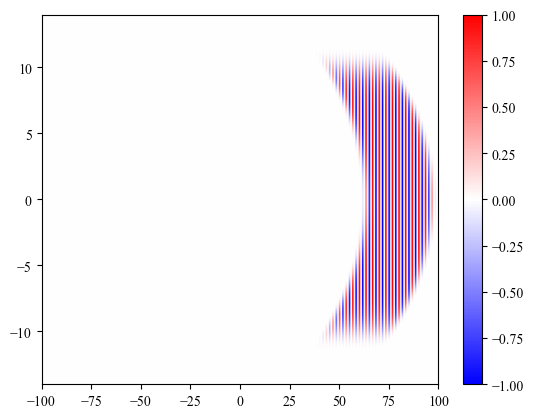

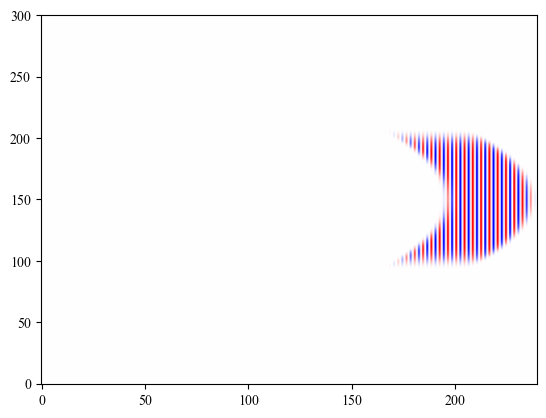

In [5]:
laser_yx = laser[:, z.size//2, :]

plt.imshow(laser_yx.real, aspect='auto', origin='lower', cmap='bwr', 
           extent=[t[0], t[-1], y[0], y[-1]], vmin=-1, vmax=1)
plt.xlim(-100, 100)
plt.ylim(-14, 14)
plt.colorbar()



t_lo = np.argmin(np.abs(t + 100))
t_hi = np.argmin(np.abs(t - 100))

plt.figure()
et_clipped = laser_yx[:, t_lo:t_hi]
plt.imshow(et_clipped.real, aspect='auto', origin='lower', cmap='bwr', vmin=-1, vmax=1)

E_r = et_clipped.T
#LASER_START = 80e-15
LASER_START = (8.5 / constants.C_UM_FS) * 1e-15
t_vals = np.linspace(-100e-15, 100e-15, E_r.shape[0]) + LASER_START
y_vals = np.linspace(-30e-6, 30e-6, E_r.shape[1])


wavelength = 1e-6
omega = (2 * np.pi * scipy.constants.c) / wavelength
a0_si = scipy.constants.m_e * scipy.constants.c * omega / scipy.constants.e
#E0_peak = 80 * a0_si
E0_peak = 80 * a0_si
E_r = (E_r / np.abs(E_r).max()) * E0_peak


N_t = 1600
T_MAX = 800e-15
new_t = np.linspace(0, T_MAX, N_t)
new_r = np.linspace(-14e-6, 14e-6, 480)

T_new, R_new = np.meshgrid(new_t, new_r, indexing='ij')

points_in = (t_vals, y_vals)
points_out = (new_t, new_r)

interp_func = scipy.interpolate.RegularGridInterpolator(
    points_in, np.abs(E_r)**2, 
    bounds_error=False, fill_value=0, method='cubic'
)

I_r_interp = interp_func((T_new, R_new))

I_r_interp *= scipy.constants.epsilon_0 * scipy.constants.c

Peak Intensity [W/cm^2]: 1.7512551040648231e+22


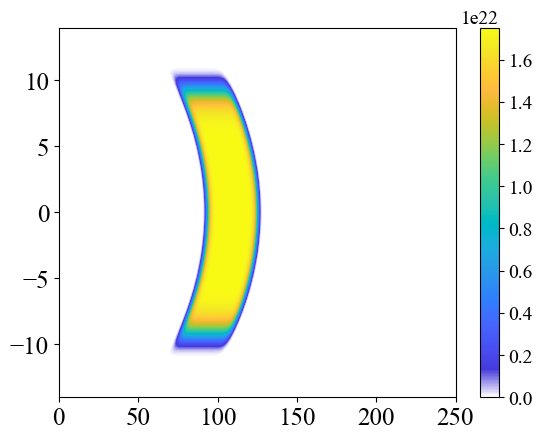

In [6]:
plt.figure()
FONT_SIZE = 16
I_r_interp_w_cm_e22 = I_r_interp * (1/(100**2))
plt.imshow(I_r_interp_w_cm_e22.real.T, aspect='auto', origin='lower', cmap=cmap, 
           extent=[new_t[0] * 1e15, new_t[-1] * 1e15, new_r[0] * 1e6, new_r[-1] * 1e6])
plt.xlim(0, 250)
plt.tick_params(axis='both', which='major', labelsize=FONT_SIZE+2)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.get_offset_text().set_fontsize(14)
#plt.savefig(FIGURE_DIRECTORY + "pw45_a2_intensity.png")

print("Peak Intensity [W/cm^2]:", I_r_interp_w_cm_e22.max())

In [7]:
print(laser.shape)
laser_shifted = np.fft.fftshift(laser, axes=2)
laser_w = np.fft.fft(laser_shifted, axis=2)
laser_w = np.fft.ifftshift(laser_w, axes=2)

(301, 301, 601)


In [8]:
youtput = np.linspace(-60e4, 60e4, 2**8)
zoutput = youtput
print(laser_w.shape)

(301, 301, 601)


In [9]:
print("Propagating laser")
prop_distance = 2.5e6
Ew_output = propagate_frequencies(y, z, youtput, zoutput, prop_distance, w, laser_w)

Propagating laser


In [10]:
f = np.abs(prop_distance)
Y_OUTPUT, Z_OUTPUT = np.meshgrid(youtput, zoutput, indexing='ij')
efield_no_lens = np.zeros((youtput.size, zoutput.size, w.size), dtype=np.complex64)

for index, omega in enumerate(w):
    
    efield_slice = Ew_output[:, :, index]
    wvl = (2 * np.pi * constants.C_UM_FS) / omega
    k_val = omega / constants.C_UM_FS
    

    lens = np.sqrt(Y_OUTPUT ** 2 + Z_OUTPUT ** 2 + f ** 2)

    Tx = np.array(np.exp(-1j * k_val * lens), dtype=np.complex64)
    efield_no_lens[:, :, index] = np.multiply(efield_slice, Tx)
    

In [11]:
output_field_t = convert_to_time(efield_no_lens)

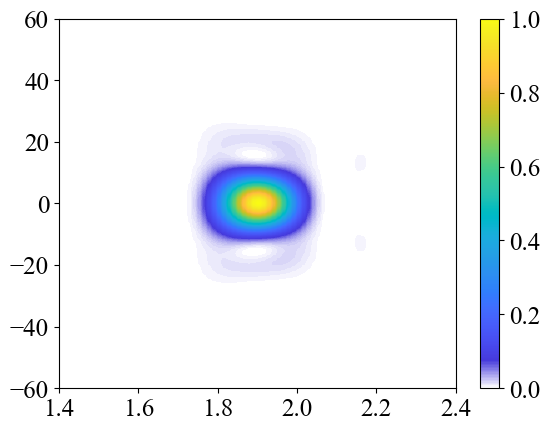

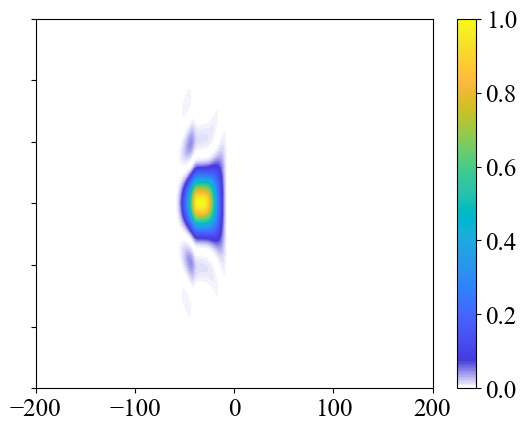

In [12]:

spectral_intensity = np.abs(efield_no_lens[:, youtput.size//2, :])**2
spectral_intensity = spectral_intensity / spectral_intensity.max()

temporal_intensity = np.roll(np.abs(output_field_t[:, youtput.size//2, :])**2, 150)
temporal_intensity = temporal_intensity / temporal_intensity.max()

plt.figure()
plt.imshow(spectral_intensity, origin='lower', 
           aspect='auto', extent=[w.min(), w.max(), youtput.min() * 1e-4, youtput.max() * 1e-4], cmap=cmap)
plt.xlim(1.4, 2.4)
plt.tick_params(labelbottom=True, labelsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
#plt.savefig(FIGURE_DIRECTORY + "input_spectral_intensity_45pw.png")

plt.figure()
plt.imshow(temporal_intensity, origin='lower', 
           aspect='auto', extent=[t[0], t[-1], youtput[0] * 1e-4, youtput[-1] * 1e-4], cmap=cmap)
plt.xlim(-200, 200)
plt.tick_params(labelleft=False, labelbottom=True, labelsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
#plt.savefig(FIGURE_DIRECTORY + "input_temporal_intensity_45pw.png")

### Echelon Pulse

In [13]:
# Propagation Parameters

SPATIAL_DIMENSIONS = 2
PROPAGATION_TYPE = constants.RAYLEIGH_SOMMERFELD
MONOCHROMATIC_ASSUMPTION = False

# INPUT PLANE
#Y_INPUT_RANGE = 10 * 7.5e4
Y_INPUT_RANGE = 3 * 20e4
Z_INPUT_RANGE = Y_INPUT_RANGE
N_Y_INPUT = (2 ** 8)
N_Z_INPUT = (2 ** 8)
Y_VALS_INPUT = np.linspace(-Y_INPUT_RANGE, Y_INPUT_RANGE, N_Y_INPUT)
Z_VALS_INPUT = np.linspace(-Z_INPUT_RANGE, Z_INPUT_RANGE, N_Z_INPUT)

# OUTPUT PLANE
Y_OUTPUT_RANGE = 30
Z_OUTPUT_RANGE = Y_OUTPUT_RANGE
N_Y_OUTPUT = (2 ** 8) + 1
N_Z_OUTPUT = (2 ** 8) + 1
Y_VALS_OUTPUT = np.linspace(-Y_OUTPUT_RANGE, Y_OUTPUT_RANGE, N_Y_OUTPUT)
Z_VALS_OUTPUT = np.linspace(-Z_OUTPUT_RANGE, Z_OUTPUT_RANGE, N_Z_OUTPUT)

# TIME DIMENSION
T_RANGE = 800
N_T = (2 ** 11)

TIMES = np.linspace(-T_RANGE, T_RANGE, N_T)
TIMES -= 0.000001
DT = TIMES[1] - TIMES[0]
OMEGAS = np.fft.fftshift(np.fft.fftfreq(len(TIMES), DT / (2*np.pi)))
OMEGAS -= 0.0000001

# OTHER
SAVE_DATA_AS_FILES = False
SIM_DIRECTORY_FP = "../"
DATA_DIRECTORY_PATH = SIM_DIRECTORY_FP + "trash/"
LOW_MEM = False # False is faster (haven't run benchmarks on how much faster), but requires more RAM

In [14]:
### Laser Parameters
WAVELENGTH = .800  # um
REF_FREQ = (2*np.pi*constants.C_SPEED) / (WAVELENGTH * 1e-6)
OMEGA0 = REF_FREQ * 1e-15  # rad / PHz

POLARIZATION = constants.LINEAR_Y
SPATIAL_SHAPE = constants.ECHELON
SPATIAL_GAUSSIAN_ORDER = 1
TEMPORAL_SHAPE = constants.GAUSSIAN_T
TEMPORAL_GAUSSIAN_ORDER = 1
PHASE_OFFSET = 0  # Constant phase shift


#WAIST_IN = 20e4
WAIST_IN = 20e4


# Used for beams with an annulus
#DELTAX = 3.072506017553855 * WAIST_IN
DELTAX = 0

# Used for spatial chirp
USE_GRATING_EQ = False
ALPHA = 0
GRATING_SEPARATION =[-102e4]
GRATING_ANGLE_OF_INCIDENCE = [np.deg2rad(22.8)]
GROOVE_PERIOD = [1 / 1480e-3]
DIFFRACTION_ORDER = [1]

PULSE_FWHM = 30.
SPOT_SIZE = 0.6
OUTPUT_DISTANCE_FROM_FOCUS = -30.

NORMALIZE_TO_A0 = False
PEAK_A0 = 21.
TOTAL_ENERGY = 203144608.7520115

# Used for LG beams
L = 1

# Used for petal beams
NUM_PETALS = 4
WAIST_IN_RADIAL = 20e4
WAIST_IN_AZIMUTHAL = (20/1) * 1e4

CENTER_PEAK_EFIELD_AT_0 = True
GRATING_ANGLE_OF_INCIDENCE = np.array([np.deg2rad(52.8)])
AXICON_ANGLE = .000001
#ECHELON_DELAY = 110 # fs
ECHELON_DELAY = 70

USE_THICK_LENS = False
R1_LENS = 15e6
R2_LENS = np.inf
LENS_CENTER_THICKNESS = 2e3

propagation_parameters_obj = structs.PropagationParameters(
    spatial_dimensions=SPATIAL_DIMENSIONS, propagation_type=PROPAGATION_TYPE, monochromatic_assumption=MONOCHROMATIC_ASSUMPTION, 
    y_input_range=Y_INPUT_RANGE, z_input_range=Z_INPUT_RANGE, N_y_input=N_Y_INPUT, N_z_input=N_Z_INPUT, 
    y_vals_input=Y_VALS_INPUT, z_vals_input=Z_VALS_INPUT, y_output_range=Y_OUTPUT_RANGE, z_output_range=Z_OUTPUT_RANGE,
    N_y_output=N_Y_OUTPUT, N_z_output=N_Z_OUTPUT, y_vals_output=Y_VALS_OUTPUT, z_vals_output=Z_VALS_OUTPUT,
    N_t=N_T, t_range=T_RANGE, times=TIMES, omegas=OMEGAS, save_data_as_files=SAVE_DATA_AS_FILES,
    sim_directory = SIM_DIRECTORY_FP, data_directory_path=DATA_DIRECTORY_PATH, low_mem=LOW_MEM
)

laser_parameters_obj = structs.LaserParameters(
    wavelength=WAVELENGTH, ref_freq=REF_FREQ, omega0=OMEGA0, polarization=POLARIZATION,
    spatial_shape=SPATIAL_SHAPE, spatial_gaussian_order=SPATIAL_GAUSSIAN_ORDER, temporal_shape=TEMPORAL_SHAPE,
    temporal_gaussian_order=TEMPORAL_GAUSSIAN_ORDER, phase_offset=PHASE_OFFSET, deltax=DELTAX, pulse_fwhm=PULSE_FWHM, 
    spot_size=SPOT_SIZE, waist_in=WAIST_IN, output_distance_from_focus=OUTPUT_DISTANCE_FROM_FOCUS, 
    normalize_to_a0=NORMALIZE_TO_A0, peak_a0=PEAK_A0, total_energy=TOTAL_ENERGY, l=L, num_petals=NUM_PETALS, 
    waist_in_radial=WAIST_IN_RADIAL, waist_in_azimuthal=WAIST_IN_AZIMUTHAL
)

# Advanced Parameters
GRATING_PARAMS = structs.GratingParameters(
    use_grating_eq=USE_GRATING_EQ,
    alpha=ALPHA,
    grating_aois=GRATING_ANGLE_OF_INCIDENCE,
    groove_periods=GROOVE_PERIOD,
    diffraction_orders=DIFFRACTION_ORDER,
    grating_separations=GRATING_SEPARATION
)


THICK_LENS = structs.get_thick_lens_params(
    USE_THICK_LENS, R1_LENS, R2_LENS, LENS_CENTER_THICKNESS
)

advanced_parameters_obj = structs.AdvancedParameters(
    center_peak_E_at_0=CENTER_PEAK_EFIELD_AT_0,
    grating_params=GRATING_PARAMS,
    axicon_angle=AXICON_ANGLE,
    echelon_delay=ECHELON_DELAY,
    thick_lens=THICK_LENS
)

In [15]:
# Create the laser object
input_field = input_laser_field.InputField(propagation_parameters_obj, laser_parameters_obj, 
                                           advanced_parameters_obj, verbose=True)

# Populate the input grid
input_field.generate_input_Ew_field(req_low_mem = True)

#### Ranges ####
Spatial Dimensions: 2
Y Input Range: -600000.0 600000.0
Z Input Range: -600000.0 600000.0
Y Output Range: -30.0 30.0
Z Output Range: -30.0 30.0
Time Range: -800.000001 799.999999
Omega Range: -4.01927520118667 4.0153499278456675
#### Resolutions ####
Dy Input: 4705.882352941204
Dz Input: 4705.882352941204
Dy Output: 0.234375
Dz Output: 0.234375
Dt: 0.7816316560820269
Dw: 0.003925073341002339
#### Other Parameters ####
Omega0: 2.354564459136067
Delta Omega: 0.07849400150103164
Entrance Waist: 200000.0
Focus: 471238.89803634846
F#: 1.178097245090871
Using alpha: 0
Angle at Focus: 0.0
Beta BA: 1.0


(1.5, 2.5)

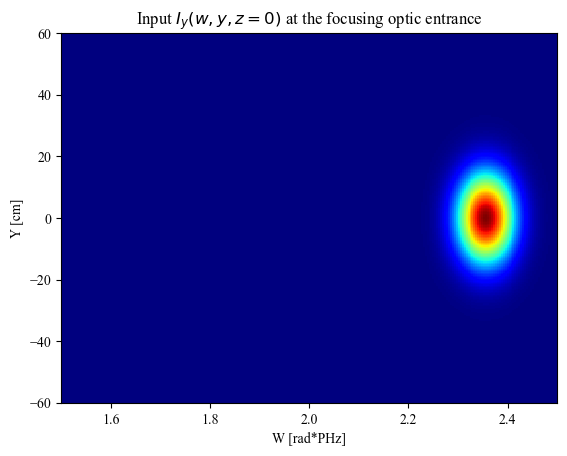

In [16]:
wbound = input_field.prop.omegas.max()
ew_input = laser_visualization.get_Ew_YW(input_field, z_val=0, is_Ey=True, ybound=0, wbound=wbound, is_output=False)

start_index = np.argmin(np.abs(input_field.prop.omegas - 0))
end_index = np.argmin(np.abs(input_field.prop.omegas - wbound))

ew_input_imshow = np.flip(ew_input[start_index:end_index, :].T, axis=0)

Iw_input_imshow = np.abs(ew_input_imshow) ** 2
Iw_input_imshow = Iw_input_imshow / Iw_input_imshow.max()

plt.figure()
plt.imshow(Iw_input_imshow, aspect='auto', extent=[0, wbound, -input_field.prop.y_input_range * 1e-4, input_field.prop.y_input_range * 1e-4], cmap='jet', interpolation="None")
plt.xlabel('W [rad*PHz]')
plt.ylabel('Y [cm]')
plt.title("Input $I_{y}(w, y, z=0)$ at the focusing optic entrance")
plt.xlim(1.5, 2.5)

Text(0.5, 0, 'Z [cm]')

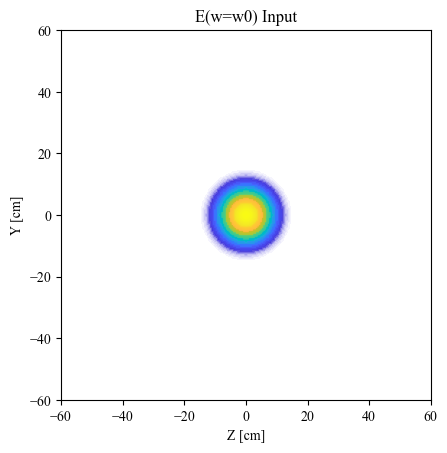

In [17]:
laser_ey = np.sum(input_field.input_Ew_field_y, axis=0)
laser_ez = np.sum(input_field.input_Ew_field_z, axis=0)

laser_echelon = np.abs(laser_ey)**2 + np.abs(laser_ez)**2

plt.imshow(laser_echelon, aspect='equal', origin='lower', cmap=cmap, 
           extent=[-Z_INPUT_RANGE * 1e-4, Z_INPUT_RANGE * 1e-4, -Y_INPUT_RANGE * 1e-4, Y_INPUT_RANGE * 1e-4])

plt.title("E(w=w0) Input")
plt.ylabel("Y [cm]")
plt.xlabel("Z [cm]")

Text(0.5, 0, 'Z [cm]')

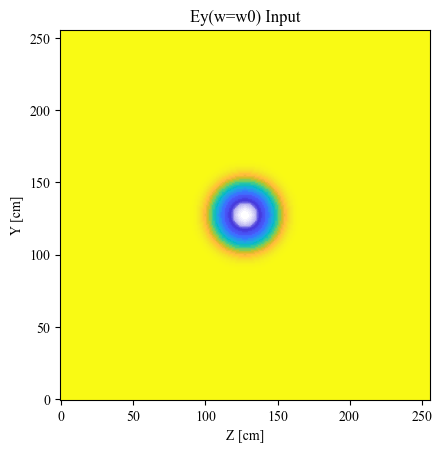

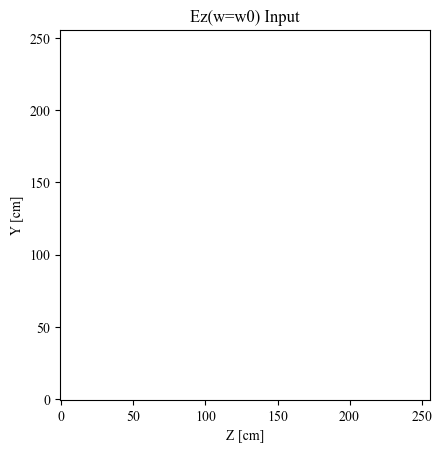

In [18]:
laser_ey = np.sum(input_field.input_Ew_field_y, axis=0)
laser_ez = np.sum(input_field.input_Ew_field_z, axis=0)

plt.figure()
plt.imshow(laser_ey.real, aspect='equal', origin='lower', cmap=cmap)

plt.title("Ey(w=w0) Input")
plt.ylabel("Y [cm]")
plt.xlabel("Z [cm]")

plt.figure()
plt.imshow(laser_ez.real, aspect='equal', origin='lower', cmap=cmap)

plt.title("Ez(w=w0) Input")
plt.ylabel("Y [cm]")
plt.xlabel("Z [cm]")


In [19]:
print("Generating Input Et Field")
propagator.generate_input_Et_field(input_field)

Generating Input Et Field


(-50.0, 50.0)

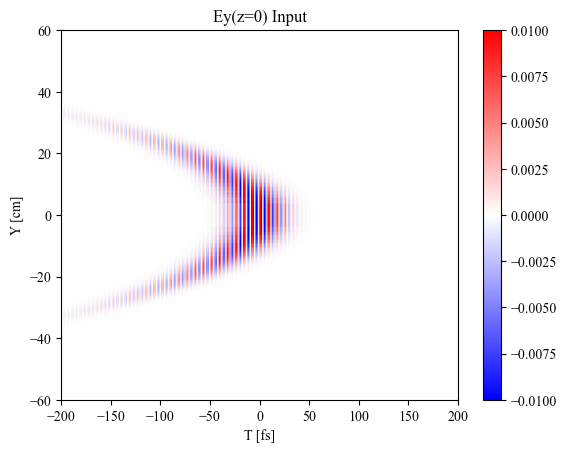

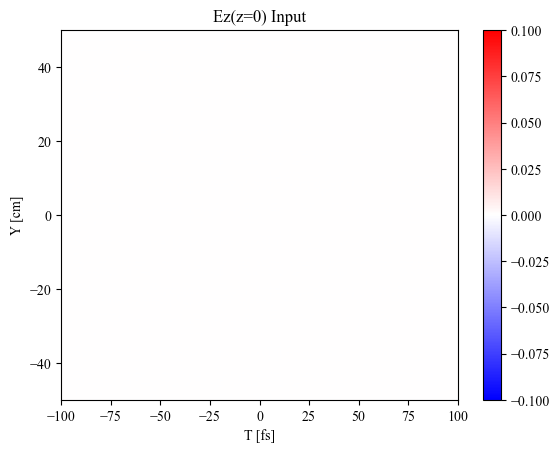

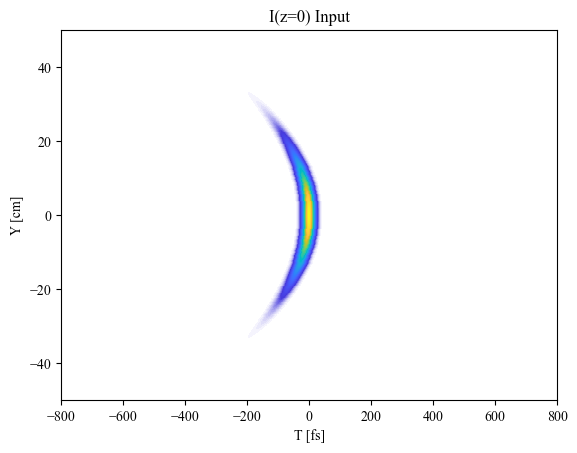

In [20]:
shape = input_field.input_Et_field_y.shape
laser_ey = np.flip(input_field.input_Et_field_y[:, :, shape[2]//2], axis=1)
laser_ez = np.flip(input_field.input_Et_field_z[:, :, shape[2]//2], axis=1)

plt.figure()
plt.imshow(laser_ey.real, aspect='auto', origin='lower', cmap='bwr', 
           extent=[-input_field.prop.t_range, input_field.prop.t_range, 
                   -input_field.prop.y_input_range * 1e-4, input_field.prop.y_input_range * 1e-4], vmin=-.01, vmax=.01)
plt.colorbar()

plt.title("Ey(z=0) Input")
plt.ylabel("Y [cm]")
plt.xlabel("T [fs]")
plt.xlim(-200, 200)

plt.figure()
plt.imshow(laser_ez.real, aspect='auto', origin='lower', cmap='bwr', 
           extent=[-input_field.prop.t_range, input_field.prop.t_range, 
                   -input_field.prop.y_input_range * 1e-4, input_field.prop.y_input_range * 1e-4])
plt.colorbar()

plt.title("Ez(z=0) Input")
plt.ylabel("Y [cm]")
plt.xlabel("T [fs]")
plt.xlim(-100, 100)
plt.ylim(-50, 50)

plt.figure()
plt.imshow(np.abs(laser_ez)**2 + np.abs(laser_ey)**2, aspect='auto', origin='lower', cmap=cmap, 
           extent=[-input_field.prop.t_range, input_field.prop.t_range, 
                   -input_field.prop.y_input_range * 1e-4, input_field.prop.y_input_range * 1e-4])

plt.title("I(z=0) Input")
plt.ylabel("Y [cm]")
plt.xlabel("T [fs]")
plt.ylim(-50, 50)


In [21]:
spectral_intensity = np.abs(input_field.input_Ew_field_y)**2 + np.abs(input_field.input_Ew_field_z)**2
spectral_intensity = spectral_intensity[:, spectral_intensity.shape[1]//2, :]
spectral_intensity = spectral_intensity / spectral_intensity.max()

temporal_intensity = np.abs(input_field.input_Et_field_y)**2 + np.abs(input_field.input_Et_field_z)**2
temporal_intensity = temporal_intensity[temporal_intensity.shape[0]//2] / temporal_intensity.max()



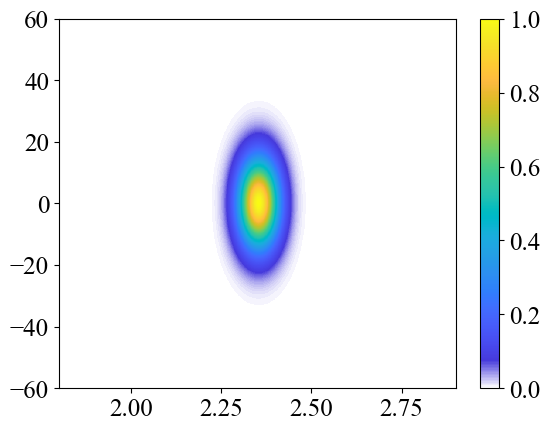

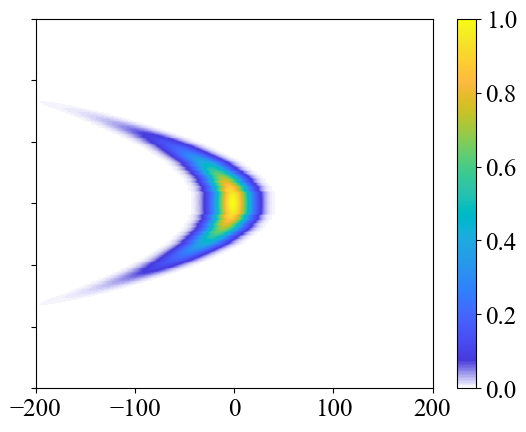

In [22]:
plt.figure()
plt.imshow(spectral_intensity.T, origin='lower', 
           aspect='auto', extent=[input_field.prop.omegas.min(), input_field.prop.omegas.max(), 
                                  -input_field.prop.y_input_range * 1e-4, input_field.prop.y_input_range * 1e-4], cmap=cmap)
plt.xlim(1.8, 2.9)
plt.tick_params(labelsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
#plt.savefig(FIGURE_DIRECTORY + "input_spectral_intensity_1pw_echelon.png")

plt.figure()
plt.imshow(np.flip(temporal_intensity.T, axis=1), origin='lower', 
           aspect='auto', extent=[-input_field.prop.t_range, input_field.prop.t_range, -input_field.prop.y_input_range * 1e-4, input_field.prop.y_input_range * 1e-4], cmap=cmap)
plt.xlim(-200, 200)
plt.tick_params(labelleft=False, labelsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
#plt.savefig(FIGURE_DIRECTORY + "input_temporal_intensity_1pw_echelon.png")

In [23]:
print("Generating Output Ew Field")
propagator.generate_output_Ew_field(input_field)

Generating Output Ew Field


Text(0.5, 1.0, 'Output $I_{y}(w, y, z=0)$ at -30.0$\\mu m$ from the focus')

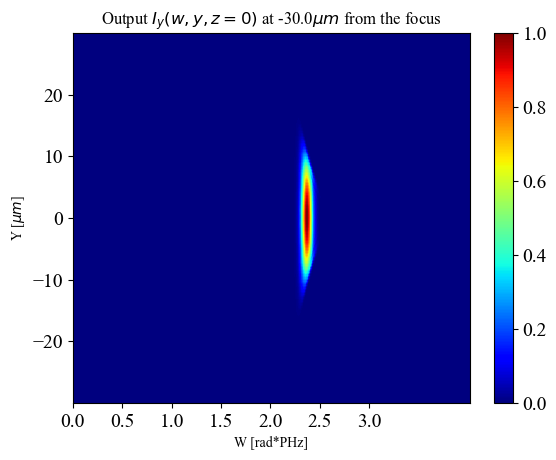

In [24]:
plt.figure()

ybound = Y_OUTPUT_RANGE
wbound = input_field.prop.omegas.max()
ew_output = laser_visualization.get_Ew_YW(input_field, z_val=0, is_Ey=True, ybound=ybound, wbound=wbound, is_output=True)

start_index = np.argmin(np.abs(input_field.prop.omegas - 0))
end_index = np.argmin(np.abs(input_field.prop.omegas - wbound))

ew_output_imshow = np.flip(ew_output[start_index:end_index, :].T, axis=0)

Iw_output_imshow = np.abs(ew_output_imshow)**2
Iw_output_imshow = Iw_output_imshow / Iw_output_imshow.max()

plt.imshow(Iw_output_imshow.real, aspect='auto', extent=[0, wbound, -ybound, ybound], cmap='jet', interpolation="None")
plt.xticks(np.array([0, .5, 1, 1.5, 2, 2.5, 3]), fontsize=14)
plt.yticks(np.array([-20, -10, 0, 10, 20]), fontsize=14)
cbar = plt.colorbar(ticks=[0, .2, .4, .6, .8, 1])
cbar.ax.tick_params(labelsize=14)
plt.xlabel('W [rad*PHz]')
plt.ylabel('Y [$\\mu m$]')
plt.title("Output $I_{y}(w, y, z=0)$ at " + str(OUTPUT_DISTANCE_FROM_FOCUS) + "$\\mu m$ from the focus")

Text(0.5, 1.0, 'Output $I_{y}(w=omega0, y, z)$ at -30.0$\\mu m$ from the focus')

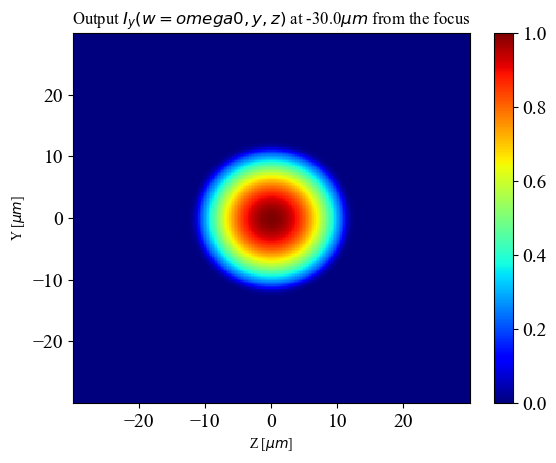

In [25]:
plt.figure()

ybound = Y_OUTPUT_RANGE
wbound = input_field.prop.omegas.max()
ew_output = laser_visualization.get_Ew_transverse(input_field, w = OMEGA0, is_Ey=True, ybound=ybound, is_output=True)

Iw_output_imshow = np.abs(ew_output)**2
Iw_output_imshow = Iw_output_imshow / Iw_output_imshow.max()

plt.imshow(Iw_output_imshow.real, aspect='auto', extent=[-ybound, ybound, -ybound, ybound], cmap='jet', interpolation="None")
plt.xticks(np.array([-20, -10, 0, 10, 20]), fontsize=14)
plt.yticks(np.array([-20, -10, 0, 10, 20]), fontsize=14)
cbar = plt.colorbar(ticks=[0, .2, .4, .6, .8, 1])
cbar.ax.tick_params(labelsize=14)
plt.xlabel('Z [$\\mu m$]')
plt.ylabel('Y [$\\mu m$]')
plt.title("Output $I_{y}(w=omega0, y, z)$ at " + str(OUTPUT_DISTANCE_FROM_FOCUS) + "$\\mu m$ from the focus")

In [26]:
print("Generating Output Et Field")
propagator.generate_output_Et_field_from_Ew(input_field)

Generating Output Et Field


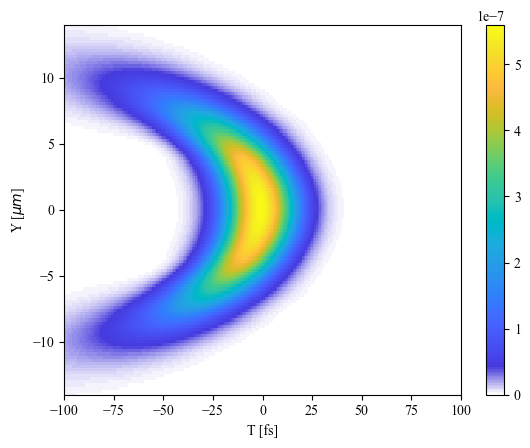

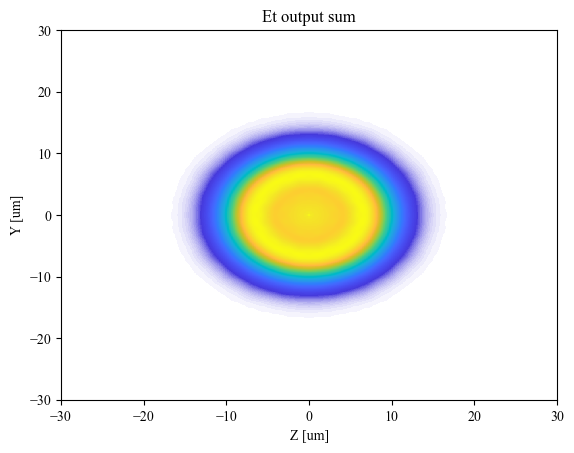

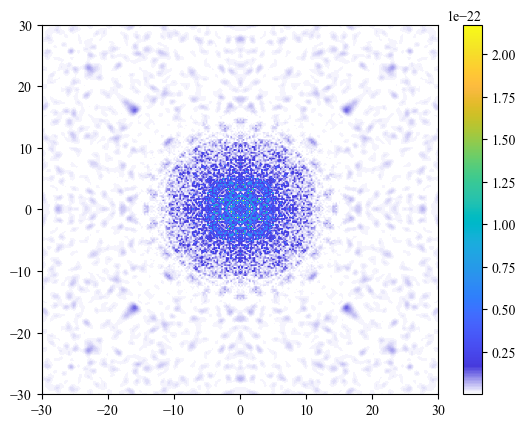

In [27]:
plt.figure()

ybound = Y_OUTPUT_RANGE
tbound = input_field.prop.times.max()
et_output = laser_visualization.get_Et_YT(input_field, z_val=0, is_Ey=True, ybound=ybound, tbound=tbound, is_output=True)

et_output_imshow = np.flip(et_output[:, :].T, axis=1)
It_y = np.abs(et_output_imshow)**2
et_output_imshow = et_output_imshow / np.abs(et_output_imshow.real).max()


plt.imshow(np.roll(It_y.real, 0, axis=1), origin='lower', aspect='auto', extent=[-tbound, tbound, -ybound, ybound], 
           cmap=cmap, interpolation="None")
plt.colorbar()
plt.xlabel('T [fs]')
plt.ylabel('Y [$\\mu m$]')
plt.xlim(-100, 100)
plt.ylim(-14, 14)

plt.figure()
laser_ey = np.sum(np.abs(input_field.output_Et_field_y), axis=1)
laser_ez = np.sum(np.abs(input_field.output_Et_field_z), axis=1)

laser_p = np.abs(laser_ey)**2 + np.abs(laser_ez)**2

plt.imshow(laser_p, aspect='auto', origin='lower', cmap=cmap, extent=[-ybound, ybound, -ybound, ybound])

plt.title("Et output sum")
plt.ylabel("Y [um]")
plt.xlabel("Z [um]")

plt.figure()
t_index = np.argmin(np.abs(input_field.prop.times + 120))
cross_section = np.abs(input_field.output_Et_field_y[:, t_index, :])**2 + np.abs(input_field.output_Et_field_z[:, t_index, :])**2
plt.imshow(cross_section, aspect='auto', origin='lower', cmap=cmap, extent=[-ybound, ybound, -ybound, ybound])
plt.colorbar()

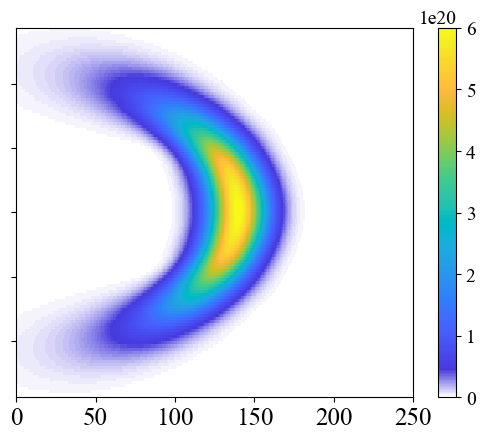

In [28]:
temporal_intensity = np.roll(It_y.real, 180, axis=1)
a0_peak = 11.85

a0_si = scipy.constants.m_e * scipy.constants.c * (OMEGA0 * 1e15) / scipy.constants.e

temporal_intensity = (temporal_intensity / temporal_intensity.max()) * (a0_peak * a0_si)**2 * scipy.constants.epsilon_0 * scipy.constants.c
temporal_intensity = temporal_intensity * (1 / 100**2)
plt.figure()
plt.imshow(temporal_intensity, origin='lower', aspect='auto', extent=[-tbound, tbound, -ybound, ybound], 
           cmap=cmap, interpolation="None")
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.xlim(0, 250)
plt.ylim(-14.4, 14.4)
plt.tick_params(labelleft=False, labelsize=18)
cbar.ax.yaxis.get_offset_text().set_fontsize(14)
#plt.savefig(FIGURE_DIRECTORY + "echelon_pulse_focus.png")

## Run Model (Fig. 2)

In [29]:
N_t = 1600
T_MAX = 800e-15
t_range = np.linspace(0, T_MAX, N_t)
n_particles = 120
r_range = np.linspace(-14e-6, 14e-6, (4 * n_particles) - (4 - 1))
LASER_START = (8.5 / constants.C_UM_FS) * 1e-15
T_CLIP = 100 * 1e-15

y_input_si = y * 1e-6
z_input_si = z * 1e-6
t_input_si = t * 1e-15
def convert_laser_to_model_params(laser, y_input, z_input, t_input, r_output, t_output, t_clip, 
                                  laser_start, wavelength_si, E0):
    laser_yx = laser[:, z.size//2, :]
    t_lo = np.argmin(np.abs(t_input + t_clip))
    t_hi = np.argmin(np.abs(t_input - t_clip))
    t_input_clipped = t_input[t_lo:t_hi] + laser_start
    
    E_r = laser_yx[:, t_lo:t_hi].T

    omega = (2 * np.pi * scipy.constants.c) / wavelength_si
    a0_si = scipy.constants.m_e * scipy.constants.c * omega / scipy.constants.e
    E0_si = E0 * a0_si
    E_r = (E_r / np.abs(E_r).max()) * E0_si

    T_new, R_new = np.meshgrid(t_output, r_output, indexing='ij')

    points_in = (t_input_clipped, y_input)
    points_out = (t_output, r_output)

    interp_func = scipy.interpolate.RegularGridInterpolator(
        points_in, np.abs(E_r)**2, 
        bounds_error=False, fill_value=0, method='cubic'
    )
    
    I_r_interp = interp_func((T_new, R_new))
    I_r_interp *= scipy.constants.epsilon_0 * scipy.constants.c
    
    return I_r_interp


def field_term(I):
    return ((2 * I) / scipy.constants.c) * (1 / (scipy.constants.m_p * scipy.constants.c))


In [30]:
E0 = 80
WAVELENGTH_SI = 1e-6
I_paraboloid = convert_laser_to_model_params(laser, y_input_si, z_input_si, t_input_si, r_range, t_range, T_CLIP, 
                                  laser_start=LASER_START, wavelength_si=WAVELENGTH_SI, E0=E0)


I_term_paraboloid = field_term(I_paraboloid)

In [31]:
from scipy.constants import m_p, e, c, epsilon_0, m_e
                                  

def normal_vector_x(rprime, xprime):
    denom = np.sqrt(rprime**2 + xprime**2)
    return np.where(denom == 0, 0, (1 / denom) * rprime)


def normal_vector_r(rprime, xprime):
    denom = np.sqrt(rprime**2 + xprime**2)
    return np.where(denom == 0, 0, (1 / denom) * -xprime)
    
def cos_phi(nx, nr, vx, vr):
    v_mag = np.sqrt(vx**2 + vr**2)

    return np.where(v_mag == 0, 0, (nx * vx + nr * vr) / v_mag)

def beta(vx, vr):
    v_mag = np.sqrt(vx**2 + vr**2)
    return v_mag / c

def kappa(cosphi, cosalpha, beta_val):
    return (cosalpha - beta_val*cosphi) / cosalpha

def last_term(cosphi, cosalpha, beta_val):
    return (beta_val*cosphi - cosalpha) / (1 - (beta_val*cosphi)**2)
    
def dsdn(r, r0, density, foil_thickness):
    return np.abs(r/r0) / (density * foil_thickness)

def parabolic_thickness(r, d0, R_c):
    thickness = d0 * (1 - (r**2 / (2 * R_c**2)))
    return np.where(thickness > .2*d0, thickness, d0)  

d0 = 250e-9
n_cr = 100
omega0 = (2 * np.pi * constants.C_UM_FS) / 1
n_cr_si = n_cr * (epsilon_0 * m_e * (omega0 * 1e15)**2) / (e**2)

r0_indices = np.linspace(0, len(r_range) - 1, n_particles, dtype=int)  

In [32]:
def run_deformable_mirror_model(t_range, r_range, n_particles, n_density, I_term, foil_thickness):
    x = np.zeros((len(t_range), n_particles))
    r = np.zeros((len(t_range), n_particles))
    vx = np.zeros((len(t_range), n_particles))
    vr = np.zeros((len(t_range), n_particles))
    px = np.zeros((len(t_range), n_particles))
    pr = np.zeros((len(t_range), n_particles))
    drdr0 = np.zeros((len(t_range), n_particles))
    dxdr0 = np.zeros((len(t_range), n_particles))
    
    dt = t_range[1] - t_range[0] 
    
    # set r0 for each particle
    r0_indices = np.linspace(0, len(r_range) - 1, n_particles, dtype=int)  
    r0_vals = r_range[r0_indices]
    r[0] = r0_vals
    dr = r0_vals[1] - r0_vals[0]
    
    for ti in range(1, len(t_range)):
        for i, ri in enumerate(r0_indices):
#             if i == 0:
#                 drdr0[ti, i] = (r[ti-1, i+1] - r[ti-1, i]) / dr
#             elif i == len(r0_indices) - 1:
#                 drdr0[ti, i] = (r[ti-1, i] - r[ti-1, i-1]) / dr
#             else:
#                 drdr0[ti, i] = (r[ti-1, i+1] - r[ti-1, i-1]) / (2 * dr)

#             if i == 0:
#                 dxdr0[ti, i] = (x[ti-1, i+1] - x[ti-1, i]) / dr
#             elif i == len(r0_indices) - 1:
#                 dxdr0[ti, i] = (x[ti-1, i] - x[ti-1, i-1]) / dr
#             else:
#                 dxdr0[ti, i] = (x[ti-1, i+1] - x[ti-1, i-1]) / (2 * dr)
            if r0_indices.size % 2 == 0 and i == r0_indices.size//2:
                drdr0[ti, i] = (r[ti-1, i+1] - r[ti-1, i]) / dr
            elif r0_indices.size % 2 == 0 and i == (r0_indices.size//2) - 1:
                drdr0[ti, i] = (r[ti-1, i] - r[ti-1, i-1]) / dr
            elif i == 0:
                drdr0[ti, i] = (r[ti-1, i+1] - r[ti-1, i]) / dr
            elif i == len(r0_indices) - 1:
                drdr0[ti, i] = (r[ti-1, i] - r[ti-1, i-1]) / dr
            else:
                drdr0[ti, i] = (r[ti-1, i+1] - r[ti-1, i-1]) / (2 * dr)

            if r0_indices.size % 2 == 0 and i == r0_indices.size//2:
                dxdr0[ti, i] = (x[ti-1, i+1] - x[ti-1, i]) / dr
            elif r0_indices.size % 2 == 0 and i == (r0_indices.size//2) - 1:
                dxdr0[ti, i] = (x[ti-1, i] - x[ti-1, i-1]) / dr
            elif i == 0:
                dxdr0[ti, i] = (x[ti-1, i+1] - x[ti-1, i]) / dr
            elif i == len(r0_indices) - 1:
                dxdr0[ti, i] = (x[ti-1, i] - x[ti-1, i-1]) / dr
            else:
                dxdr0[ti, i] = (x[ti-1, i+1] - x[ti-1, i-1]) / (2 * dr)
            
#             if r0_indices.size % 2 == 1 and i == r0_indices.size//2:
#                 drdr0[ti, i] = (r[ti-1, i+1] - r[ti-1, i-1]) / (2*dr)
#             elif i == 0:
#                 drdr0[ti, i] = (r[ti-1, i+1] - r[ti-1, i]) / dr
#             elif i <= (r0_indices.size - 1)//2:
#                 drdr0[ti, i] = (r[ti-1, i] - r[ti-1, i-1]) / dr
#             elif i == r0_indices.size - 1:
#                 drdr0[ti, i] = (r[ti-1, i] - r[ti-1, i-1]) / dr
#             elif i > (r0_indices.size - 1)//2:
#                 drdr0[ti, i] = (r[ti-1, i+1] - r[ti-1, i]) / dr
                
#             if r0_indices.size % 2 == 1 and i == r0_indices.size//2:
#                 dxdr0[ti, i] = (x[ti-1, i+1] - x[ti-1, i-1]) / (2*dr)
#             elif i == 0:
#                 dxdr0[ti, i] = (x[ti-1, i+1] - x[ti-1, i]) / dr
#             elif i <= (r0_indices.size - 1)//2:
#                 dxdr0[ti, i] = (x[ti-1, i] - x[ti-1, i-1]) / dr
#             elif i == r0_indices.size - 1:
#                 dxdr0[ti, i] = (x[ti-1, i] - x[ti-1, i-1]) / dr
#             elif i > (r0_indices.size - 1)//2:
#                 dxdr0[ti, i] = (x[ti-1, i+1] - x[ti-1, i]) / dr

            nx = normal_vector_x(drdr0[ti, i], dxdr0[ti, i])
            nr = normal_vector_r(drdr0[ti, i], dxdr0[ti, i])

            cosalpha = nx

            cosphi = cos_phi(nx, nr, vx[ti - 1, i], vr[ti - 1, i])
            beta_val = beta(vx[ti - 1, i], vr[ti - 1, i])
            kappa_val = kappa(cosphi, cosalpha, beta_val)
            last = last_term(cosphi, cosalpha, beta_val)
            dsdn_term = dsdn(r[ti - 1, i], r[0, i], n_density, foil_thickness[i])

            pos_index = np.argmin(np.abs(r_range - r[ti-1, i]))

            # account for the ions moving with the laser
            prev_pos = x[ti - 1, i]
            light_time = prev_pos / scipy.constants.c
            curr_time = t_range[ti]
            adjusted_time = curr_time - light_time
            adjusted_time = max(adjusted_time, t_range[0])
            adjusted_index = np.argmin(np.abs(t_range - adjusted_time))
            I_curr = I_term[adjusted_index, pos_index]

            final_coeff = -kappa_val * (I_curr * cosalpha) * last * dsdn_term

            a_r = final_coeff * nr

            pr[ti, i] = pr[ti - 1, i] + a_r * dt

            a_x = final_coeff * nx
            px[ti, i] = px[ti - 1, i] + a_x * dt

            p_mag_sq = pr[ti, i]**2 + px[ti, i]**2
            gamma = np.sqrt(1 + p_mag_sq)

            vr[ti, i] = pr[ti, i] * c / gamma
            vx[ti, i] = px[ti, i] * c / gamma

            r[ti, i] = r[ti-1, i] + vr[ti-1, i] * dt
            x[ti, i] = x[ti-1, i] + vx[ti-1, i] * dt

    return r, x, vx, vr, px, pr, drdr0, dxdr0


In [33]:
foil_thickness = d0 * np.ones((n_particles))
r, x, vx, vr, px, pr, drdr0, dxdr0 = run_deformable_mirror_model(t_range, r_range, n_particles, n_cr_si, I_term_paraboloid, foil_thickness)

/var/folders/wn/_6l261dd6ssfsqpqmfrs1n0w0000gn/T/ipykernel_71373/2589162201.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return np.where(v_mag == 0, 0, (nx * vx + nr * vr) / v_mag)
/var/folders/wn/_6l261dd6ssfsqpqmfrs1n0w0000gn/T/ipykernel_71373/2589162201.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  return np.where(v_mag == 0, 0, (nx * vx + nr * vr) / v_mag)


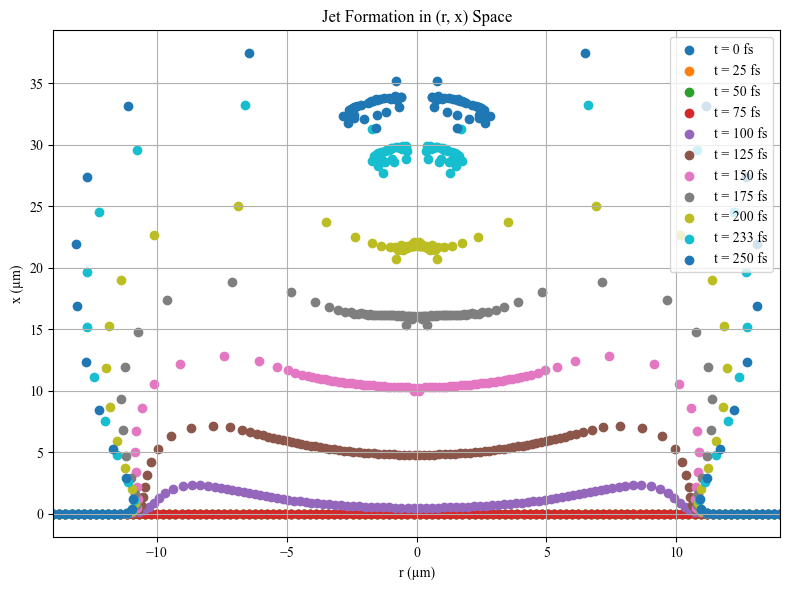

In [34]:
# === PLOT ===
plt.figure(figsize=(8, 6))
for ti in [0, 50, 100, 150, 200, 250, 300, 350, 400, 466, 500]:
    plt.scatter(r[ti]*1e6, x[ti]*1e6, label=f"t = {t_range[ti]*1e15:.0f} fs")
plt.xlabel("r (µm)")
plt.ylabel("x (µm)")
plt.title("Jet Formation in (r, x) Space")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(-14, 14)
#plt.ylim(0, 30)
plt.show()

600


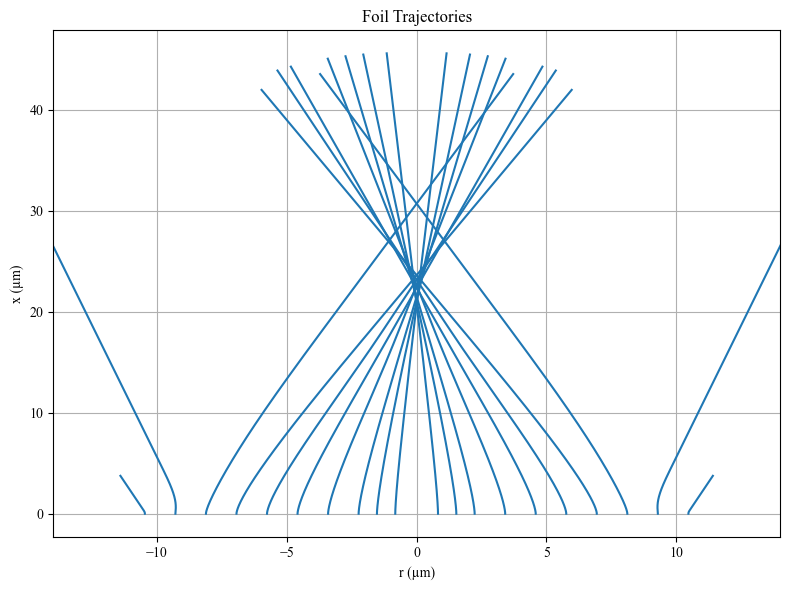

In [35]:
# === PLOT SINGLE TRAJECTORIES ===
plt.figure(figsize=(8, 6))
indices = np.array([20, 30, 40, 50, 55, 64, 69, 79, 89, 99])
indices = np.array([20, 40, 45, 50, 55, 64, 69, 74, 79, 99])
indices = np.array([15, 20, 25, 30, 35, 40, 45, 50, 53, 56, 63, 66, 69, 74, 79, 84, 89, 94, 99, 104])
T_STOP = 300 * 1e-15
t_stop_i = np.argmin(np.abs(t_range - T_STOP))
print(t_stop_i)
for i in indices:
    plt.plot(r[:t_stop_i, i]*1e6, x[:t_stop_i, i]*1e6, color='tab:blue')
plt.xlabel("r (µm)")
plt.ylabel("x (µm)")
plt.title("Foil Trajectories")

plt.grid(True)
plt.tight_layout()
plt.xlim(-14, 14)
#plt.ylim(0, 30)
plt.show()

600


(-5.0, 5.0)

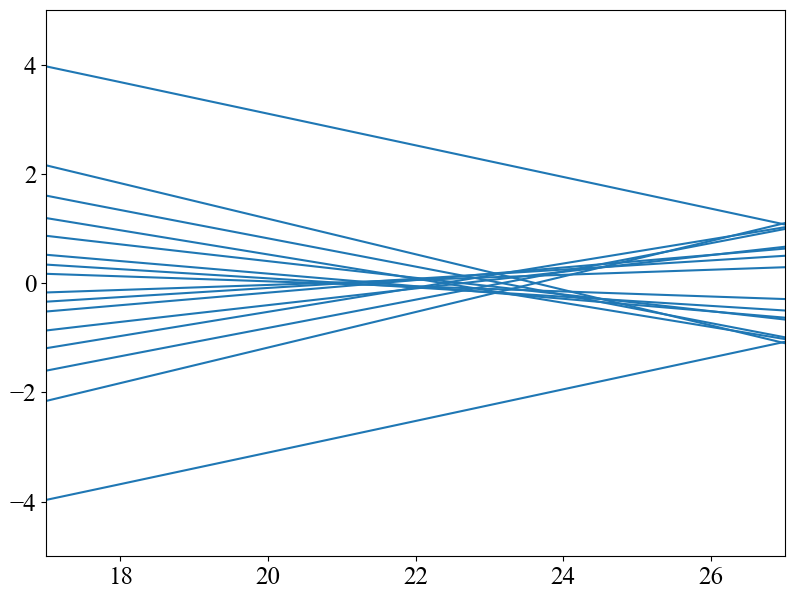

In [36]:
# === PLOT SINGLE TRAJECTORIES ===
plt.figure(figsize=(8, 6))
#indices = np.array([20, 40, 50, 55, 64, 69, 79, 99])
indices = np.array([20, 40, 45, 50, 53, 56, 63, 66, 69, 74, 79, 99])
indices = np.array([15, 20, 25, 30, 35, 40, 45, 50, 53, 56, 63, 66, 69, 74, 79, 84, 89, 94, 99, 104])
T_STOP = 300 * 1e-15
t_stop_i = np.argmin(np.abs(t_range - T_STOP))
print(t_stop_i)
for i in indices:
    plt.plot(x[:t_stop_i, i]*1e6, r[:t_stop_i, i]*1e6, color='tab:blue')

#plt.grid(True)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=FONT_SIZE+2)

plt.xlim(17, 27)
plt.ylim(-5, 5)
#plt.ylim(0, 30)
#plt.show()
#plt.savefig(FIGURE_DIRECTORY + "spherical_aberation.png")

600


(-14.0, 14.0)

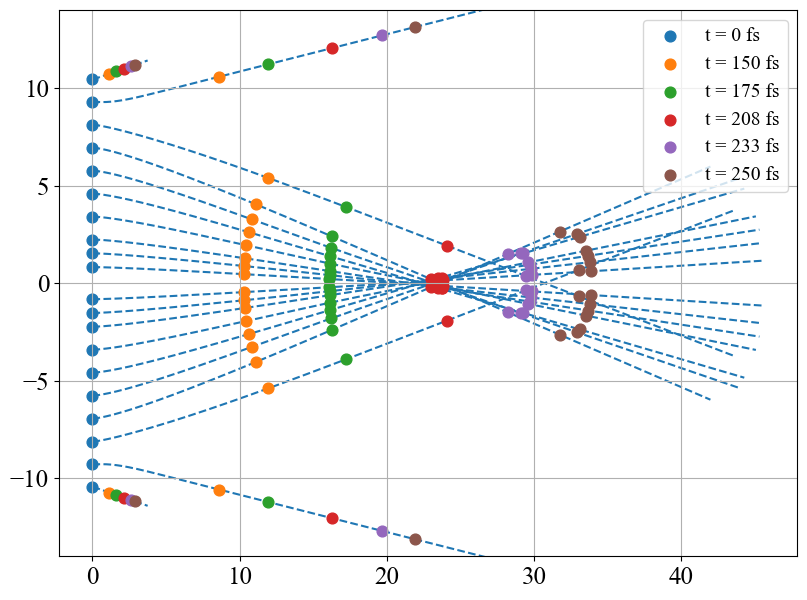

In [37]:
indices = np.array([15, 20, 25, 30, 35, 40, 45, 50, 53, 56, 63, 66, 69, 74, 79, 84, 89, 94, 99, 104])

plt.figure(figsize=(8, 6))
plt.grid(True)
T_STOP = 300 * 1e-15
t_stop_i = np.argmin(np.abs(t_range - T_STOP))
print(t_stop_i)
for i in indices:
    plt.plot(x[:t_stop_i, i]*1e6, r[:t_stop_i, i]*1e6, color='tab:blue', linestyle='--', zorder=0)

for ti in [0, 300, 350, 415, 466, 500]:
    plt.scatter(x[ti, indices]*1e6, r[ti, indices]*1e6, label=f"t = {t_range[ti]*1e15:.0f} fs", s=60)



plt.legend(fontsize=FONT_SIZE - 2)

plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=FONT_SIZE+2)
plt.ylim(-14, 14)
#plt.ylim(0, 30)
#plt.ylim(0, 30)
#plt.show()

#plt.savefig(FIGURE_DIRECTORY + "dmmodel_traj.png")

## Combine with Simulation (Fig. 3)

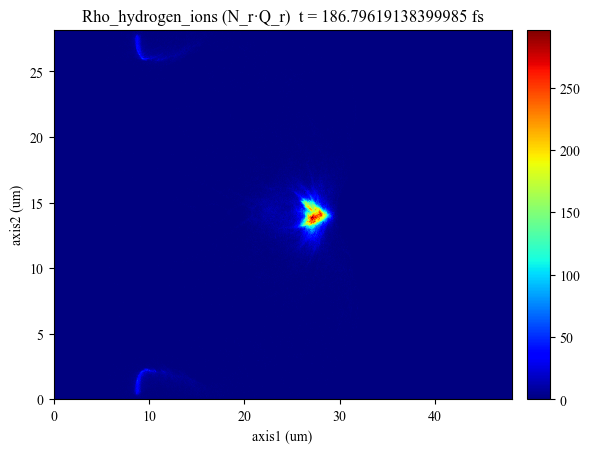

In [38]:
test = S_ppf_45pw.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = 5100)

test.plot()

In [39]:
ts_probe_1 = 2000
ts_model_1 = 73
ions = S_ppf_45pw.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_1)
ions_data_1 = np.array(ions.getData()[0])

ts_probe_2 = 2850
ts_model_2 = 105
ions = S_ppf_45pw.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_2)
ions_data_2 = np.array(ions.getData()[0])

ts_probe_3 = 3700
ts_model_3 = 135
ions = S_ppf_45pw.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_3)
ions_data_3 = np.array(ions.getData()[0])

ts_probe_4 = 4400
ts_model_4 = 161
ions = S_ppf_45pw.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_4)
ions_data_4 = np.array(ions.getData()[0])


ts_probe_6 = 5100
ts_model_6 = 187
ions = S_ppf_45pw.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_6)
ions_data_6 = np.array(ions.getData()[0])


ts_probe_7 = 5800
ts_model_7 = 212
ions = S_ppf_45pw.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_7)
ions_data_7 = np.array(ions.getData()[0])

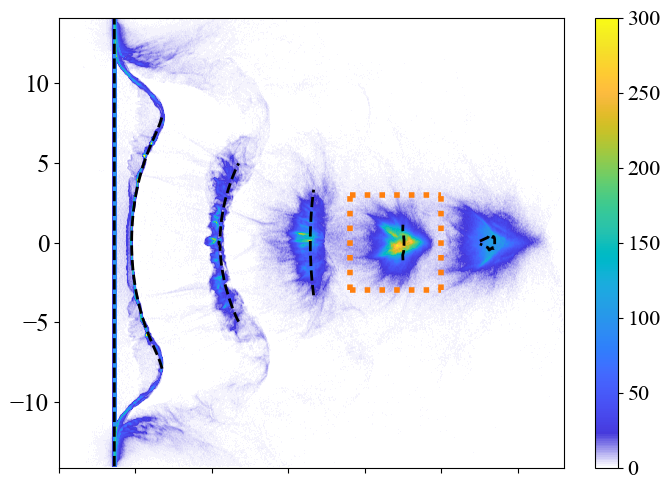

In [40]:
FOIL_POS = 8.5 + (.250 / 2)

FONT_SIZE = 16
xticks = np.array([5, 7.5, 10, 12.5])
yticks = np.array([-10, -5, 0, 5, 10])

fig, ax = plt.subplots(1, figsize=(7.1, 5))

ions_sum = np.maximum(ions_data_1.T, ions_data_2.T)
ions_sum = np.maximum(ions_sum,  ions_data_3.T)
ions_sum = np.maximum(ions_sum,  ions_data_4.T)
ions_sum = np.maximum(ions_sum,  ions_data_6.T)
ions_sum = np.maximum(ions_sum,  ions_data_7.T)
#ions_sum = np.maximum(ions_sum,  ions_data_8.T)

im = ax.imshow(ions_sum, aspect='auto', origin='lower', extent=[0, 48, -14.08, 14.08], vmin=0, vmax=300, cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=FONT_SIZE)
ax.plot(x[ts_model_1 * 2]*1e6 + FOIL_POS, r[ts_model_1 * 2]*1e6, color='black', linewidth=2, linestyle='--')

ax.plot(x[ts_model_2 * 2][np.abs(r[ts_model_2 * 2]) < 8e-6]*1e6 + FOIL_POS, 
            r[ts_model_2 * 2][np.abs(r[ts_model_2 * 2]) < 8e-6]*1e6, color='black', linewidth=2, linestyle='--')

ax.plot(x[ts_model_3 * 2][np.abs(r[ts_model_3 * 2]) < 5e-6]*1e6 + FOIL_POS, 
            r[ts_model_3 * 2][np.abs(r[ts_model_3 * 2]) < 5e-6]*1e6, color='black', linewidth=2, linestyle='--')

ax.plot(x[ts_model_4 * 2, indices][np.abs(r[ts_model_4 * 2, indices]) < 2.5e-6]*1e6 + FOIL_POS, 
            r[ts_model_3 * 2, indices][np.abs(r[ts_model_4 * 2, indices]) < 2.5e-6]*1e6, color='black', linewidth=2, linestyle='--')

ax.plot(x[ts_model_6 * 2, indices][np.abs(r[ts_model_6 * 2, indices]) < 1.5e-6]*1e6 + FOIL_POS, 
            r[ts_model_6 * 2, indices][np.abs(r[ts_model_6 * 2, indices]) < 1.5e-6]*1e6, color='black', linewidth=2, linestyle='--')

ax.plot(x[ts_model_7 * 2, indices][np.abs(r[ts_model_7 * 2, indices]) < 1.5e-6]*1e6 + FOIL_POS, 
            r[ts_model_7 * 2, indices][np.abs(r[ts_model_7 * 2, indices]) < 1.5e-6]*1e6, color='black', linewidth=2, linestyle='--')


# Focus box
plt.plot([24, 30], [3, 3], linestyle=':', color='tab:orange', linewidth=4)
plt.plot([24, 30], [-3, -3], linestyle=':', color='tab:orange', linewidth=4)
plt.plot([24, 24], [-3, 3], linestyle=':', color='tab:orange', linewidth=4)
plt.plot([30, 30], [-3, 3], linestyle=':', color='tab:orange', linewidth=4)


plt.xlim(5, 38)
ax.set_xticks([5, 10, 15, 20, 25, 30, 35])
ax.tick_params(axis='both', labelbottom=False, which='major', labelsize=FONT_SIZE + 2)
fig.tight_layout()
#plt.savefig(FIGURE_DIRECTORY + "sim_w_dmmodel.png")

In [41]:
# GAUSSIAN
ts_probe_1 = 2000
ions = S_gaussian_45pw.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_1)
ions_data_1 = np.array(ions.getData()[0])

ts_probe_2 = 2850
ions = S_gaussian_45pw.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_2)
ions_data_2 = np.array(ions.getData()[0])

ts_probe_3 = 3700
ions = S_gaussian_45pw.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_3)
ions_data_3 = np.array(ions.getData()[0])

ts_probe_4 = 4400
ions = S_gaussian_45pw.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_4)
ions_data_4 = np.array(ions.getData()[0])


ts_probe_6 = 5100
ions = S_gaussian_45pw.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_6)
ions_data_6 = np.array(ions.getData()[0])


ts_probe_7 = 5800
ions = S_gaussian_45pw.Probe(0, "Rho_hydrogen_ions", units=['um', 'fs'], cmap='jet', timesteps = ts_probe_7)
ions_data_7 = np.array(ions.getData()[0])

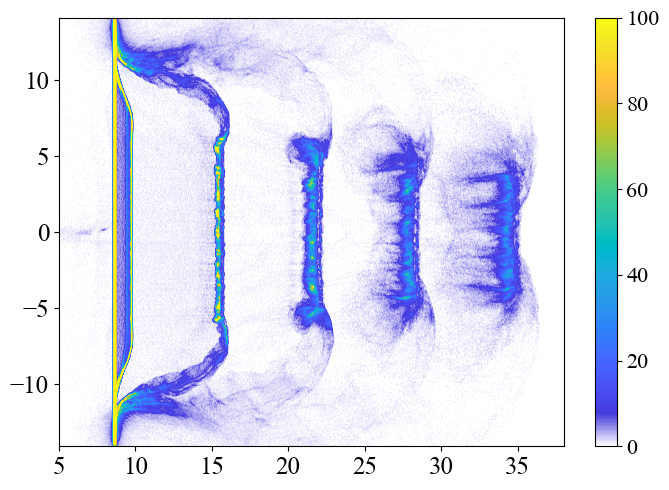

In [42]:
FOIL_POS = 8.5 + (.250 / 2)

FONT_SIZE = 16
xticks = np.array([5, 7.5, 10, 12.5])
yticks = np.array([-10, -5, 0, 5, 10])
#fig, ax = plt.subplots(1, figsize=(9, 5))
fig, ax = plt.subplots(1, figsize=(7.1, 5))

ions_sum = np.maximum(ions_data_1.T, ions_data_2.T)
ions_sum = np.maximum(ions_sum,  ions_data_3.T)
ions_sum = np.maximum(ions_sum,  ions_data_4.T)
ions_sum = np.maximum(ions_sum,  ions_data_6.T)
ions_sum = np.maximum(ions_sum,  ions_data_7.T)


im = ax.imshow(ions_sum, aspect='auto', origin='lower', extent=[0, 48, -14.08, 14.08], vmin=0, vmax=100, cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=FONT_SIZE)

plt.xlim(5, 38)
ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE + 2)
ax.set_xticks([5, 10, 15, 20, 25, 30, 35])
fig.tight_layout()
#plt.savefig(FIGURE_DIRECTORY + "gaussian_prop.png")

## Fig. 4

In [43]:
# VR
T_BEGIN = 2850
T_MIDDLE = 3700
T_END = 4400
vr_pbin_begin = S_ppf_45pw.ParticleBinning(8, units=['fs', 'um', 'MeV'], timesteps=T_BEGIN)
data_begin = np.array(vr_pbin_begin.getData()[0])
data_begin = data_begin / data_begin.max()

vr_pbin_middle = S_ppf_45pw.ParticleBinning(8, units=['fs', 'um', 'MeV'], timesteps=T_MIDDLE)
data_middle = np.array(vr_pbin_middle.getData()[0])
data_middle = data_middle / data_middle.max()

vr_pbin_end = S_ppf_45pw.ParticleBinning(8, units=['fs', 'um', 'MeV'], timesteps=T_END)
data_end = np.array(vr_pbin_end.getData()[0])
data_end = data_end / data_end.max()

vr_vals = np.linspace(0, 1., data_end.shape[0])
r_vals = np.linspace(0, 11, data_end.shape[1])

r_clip_begin = 8
r_clip_index_begin = np.argmin(np.abs(r_vals - r_clip_begin))
min_count_begin = .07
slope_begin, intercept_begin, res = get_line_fit(data_begin, vr_vals, r_vals, x_clip_min=0, 
                                                 y_clip_max=r_clip_begin, min_count=min_count_begin, 
                                                 zero_intercept=True)

print(slope_begin, intercept_begin)

r_clip_middle = 4
r_clip_index_middle = np.argmin(np.abs(r_vals - r_clip_middle))
min_count_middle = .1
slope_middle, intercept_middle, res = get_line_fit(data_middle, vr_vals, r_vals, x_clip_min=0, 
                                                 y_clip_max=r_clip_middle, min_count=min_count_middle, 
                                                 zero_intercept=True)

r_clip_end = 3
r_clip_index_end = np.argmin(np.abs(r_vals - r_clip_end))
min_count_end = .1
slope_end, intercept_end, res = get_line_fit(data_end, vr_vals, r_vals, x_clip_min=0, 
                                                 y_clip_max=r_clip_end, min_count=min_count_end, 
                                                 zero_intercept=True)

[53.83257311] 0


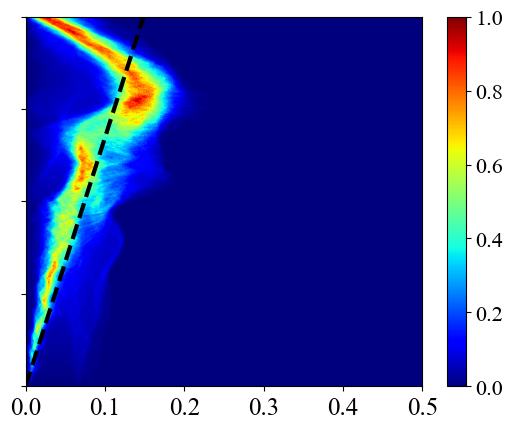

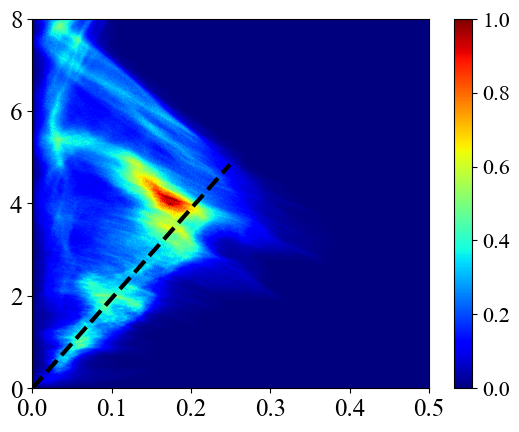

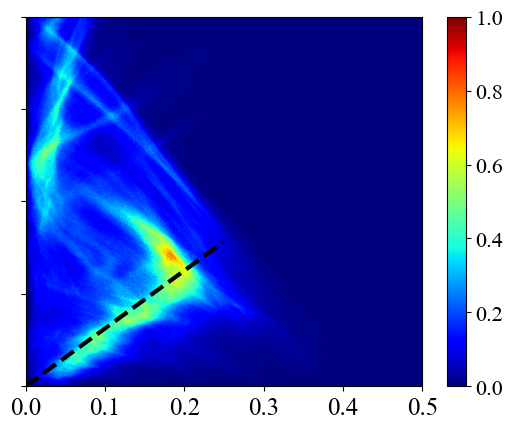

In [44]:
FONT_SIZE = 18
X_MAX = 0.5
Y_MAX = 8
x_max_index = np.argmin(np.abs(vr_vals - X_MAX))
plt.figure()
data_begin[:, :r_clip_index_begin] = data_begin[:, :r_clip_index_begin] / data_begin[:, :r_clip_index_begin].max()
plt.imshow(np.abs(data_begin[:, :r_clip_index_begin].T), aspect='auto', origin='lower', 
           extent=[0, vr_vals[-1], 0, r_clip_begin], cmap='jet')
plt.plot(vr_vals, line_vals(slope_begin, intercept_begin, vr_vals), color='black', linestyle='--', linewidth=3)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE- 2)
plt.ylim(0, Y_MAX)
plt.xlim(0, X_MAX)
plt.tick_params(labelleft=False, labelsize = FONT_SIZE)
#plt.savefig(FIGURE_DIRECTORY + "vrvx_phase_space_begin.png")

plt.figure()

data_middle = data_middle / data_middle[:x_max_index, :r_clip_index_middle].max()
plt.imshow(np.abs(data_middle[:, :].T), aspect='auto', origin='lower', 
           extent=[0, vr_vals[-1], 0, r_vals[-1]], cmap='jet', vmax=1)

stop_index = 200
plt.plot(vr_vals[:stop_index], line_vals(slope_middle, intercept_middle, vr_vals[:stop_index]), color='black', 
         linestyle='--', linewidth=3)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE- 2)
plt.ylim(0, Y_MAX)
plt.xlim(0, X_MAX)
plt.tick_params(labelsize = FONT_SIZE)
#plt.savefig(FIGURE_DIRECTORY + "vrvx_phase_space_middle.png")


plt.figure()
plt.imshow(np.abs(data_end[:, :].T), aspect='auto', origin='lower', 
           extent=[0, vr_vals[-1], 0, r_vals[-1]], cmap='jet')

stop_index = 200
plt.plot(vr_vals[:stop_index], line_vals(slope_end, intercept_end, vr_vals[:stop_index]), 
         color='black', linestyle='--', linewidth=3)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE- 2)
plt.ylim(0, Y_MAX)
plt.xlim(0, X_MAX)
plt.tick_params(labelleft=False, labelsize = FONT_SIZE)
#plt.savefig(FIGURE_DIRECTORY + "vrvx_phase_space_end.png")

In [45]:
# VX
T_BEGIN = 2850
T_MIDDLE = 3700
T_END = 4400
vx_pbin_begin = S_ppf_45pw.ParticleBinning(9, units=['fs', 'um', 'MeV'], timesteps=T_BEGIN)
data_begin = np.array(vx_pbin_begin.getData()[0])
data_begin = data_begin / data_begin.max()

vx_pbin_middle = S_ppf_45pw.ParticleBinning(9, units=['fs', 'um', 'MeV'], timesteps=T_MIDDLE)
data_middle = np.array(vx_pbin_middle.getData()[0])
data_middle = data_middle / data_middle.max()

vx_pbin_end = S_ppf_45pw.ParticleBinning(9, units=['fs', 'um', 'MeV'], timesteps=T_END)
data_end = np.array(vx_pbin_end.getData()[0])
data_end = data_end / data_end.max()

vx_vals = np.linspace(0, 1, data_end.shape[0])
r_vals = np.linspace(0, 11, data_end.shape[1])

([<matplotlib.axis.XTick at 0x7fc430b88910>,
 [Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.50'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.00')])

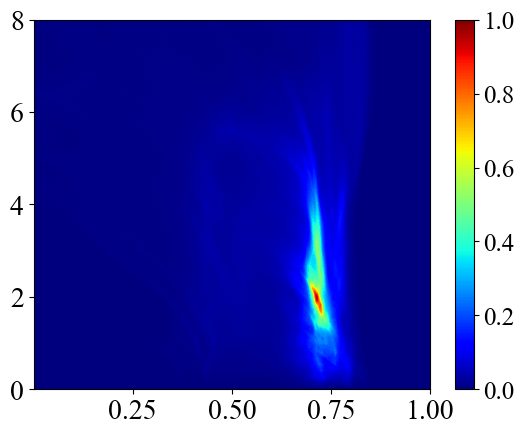

In [46]:
FONT_SIZE = 20
plt.figure()
plt.imshow(np.abs(data_end[:, :].T), aspect='auto', origin='lower', 
           extent=[0, vx_vals[-1], 0, r_vals[-1]], cmap='jet')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE- 2)
plt.ylim(0, 8)
plt.tick_params(labelsize = FONT_SIZE)
plt.xticks([0.25, 0.5, 0.75, 1])

#plt.savefig(FIGURE_DIRECTORY + "vx_phase_space_end.png")

## Fig. 5

In [47]:
screen28 = S_ppf_45pw.Screen(12, units=["um", "fs", "1/cm^3"], timesteps=99999, cmap='jet')


screen28_g = S_gaussian_45pw.Screen(12, units=["um", "fs", "1/cm^3"], timesteps=99999, cmap='jet')


In [48]:
data = np.array(screen28.getData()[0])
data_g = np.array(screen28_g.getData()[0])

y_vals = z_vals = np.linspace(-14.08, 14.08, data.shape[0])
dy = dz = y_vals[1] - y_vals[0]
Lx = 48
sim_norm = (Lx * 1e-4)
data = data * sim_norm
data_g = data_g * sim_norm

data_coulomb = data * scipy.constants.e
data_g_coulomb = data_g * scipy.constants.e

Peak charge flux: 9.688291920790297
Peak charge flux gaussian: 1.230408028330258


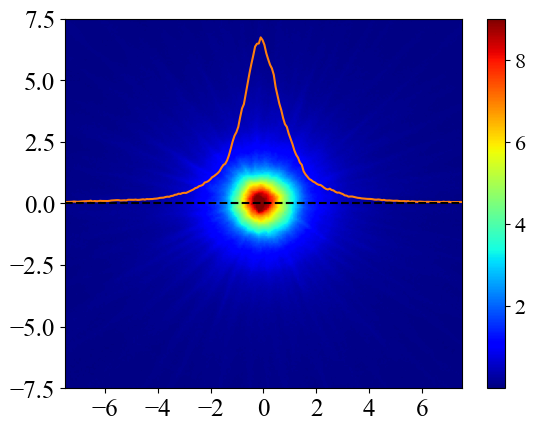

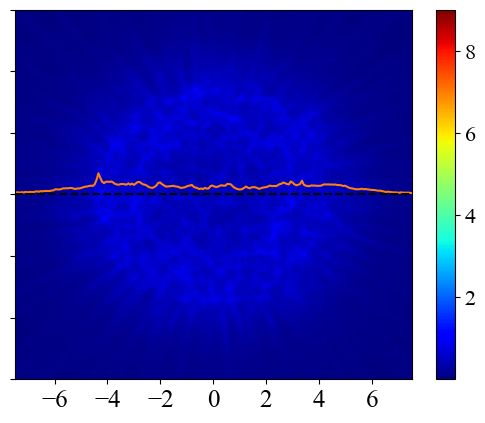

In [49]:
SCALE = .7
FONT_SIZE = 18
plt.figure()
plt.imshow(data_coulomb.T, aspect='auto', origin='lower', cmap='jet', 
           extent=[y_vals[0], y_vals[-1], z_vals[0], z_vals[-1]], vmax=9)
plt.plot(y_vals, data_coulomb[:, data_coulomb.shape[1]//2] * SCALE, color='tab:orange')
plt.axhline(y=0, color='black', linestyle='--')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE - 2)
plt.xlim(-7.5, 7.5)
plt.ylim(-7.5, 7.5)
plt.xticks([-6, -4, -2, 0, 2, 4, 6])
plt.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
print("Peak charge flux:", data_coulomb.max())
#plt.savefig(FIGURE_DIRECTORY + "screen_35pw.png")

plt.figure()
plt.imshow(data_g_coulomb.T, aspect='auto', origin='lower', cmap='jet', 
           extent=[y_vals[0], y_vals[-1], z_vals[0], z_vals[-1]], vmax=9)
plt.plot(y_vals, data_g_coulomb[:, data_g_coulomb.shape[1]//2] * SCALE, color='tab:orange')
plt.axhline(y=0, color='black', linestyle='--')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE - 2)
plt.xlim(-7.5, 7.5)
plt.ylim(-7.5, 7.5)
plt.xticks([-6, -4, -2, 0, 2, 4, 6])
plt.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
plt.tick_params(axis='y', labelleft=False)
print("Peak charge flux gaussian:", data_g_coulomb.max())
#plt.savefig(FIGURE_DIRECTORY + "screen_gaussian35pw.png")

In [50]:
data1d = data_coulomb[data_coulomb.shape[0]//2, :]
fwhm_ions = fwhm(z_vals, data1d, percent_max=0.5)
print("FWHM:", fwhm_ions)

data1d = data_g_coulomb[data_g_coulomb.shape[0]//2, :]
fwhm_ions = fwhm(z_vals, data1d, percent_max=0.5)
print("FWHM (Gaussian):", fwhm_ions)

FWHM: 1.838840187688436
FWHM (Gaussian): 9.555388126577288


In [51]:
# Spectrum
SIM_VOLUME_CM = 48e-4 * 28.16e-4 * 28.16e-4
TS = 5100
SPEC_BIN = 0
spec_ppf_45pw, energy_ppf_45pw = get_spectrum(S_ppf_45pw, SPEC_BIN, TS, SIM_VOLUME_CM)
spec_gaussian_45pw, energy_gaussian_45pw = get_spectrum(S_gaussian_45pw, SPEC_BIN, TS, SIM_VOLUME_CM)

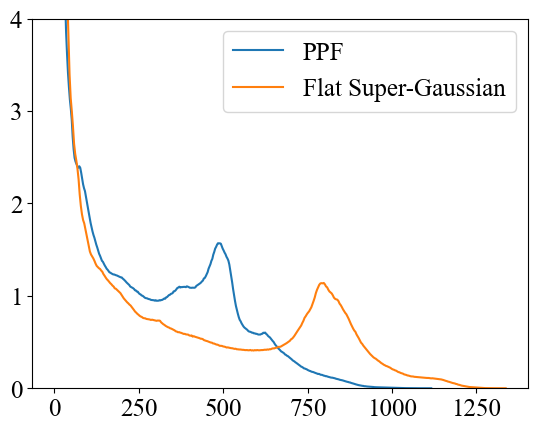

In [52]:
plt.figure()

plt.plot(energy_ppf_45pw, spec_ppf_45pw * 1e-10, label="PPF")
plt.plot(energy_gaussian_45pw, spec_gaussian_45pw * 1e-10, label="Flat Super-Gaussian")
plt.ylim(0, 4)
plt.legend(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
#plt.savefig(FIGURE_DIRECTORY + "spectrum_35pw.png")

In [53]:
print(energy_ppf_45pw[100])
peak_index_p_a2 = np.argmax(spec_ppf_45pw[100:])
peak_index_gaussian = np.argmax(spec_gaussian_45pw[100:])
print(energy_ppf_45pw[100:][peak_index_p_a2])
print(energy_gaussian_45pw[100:][peak_index_gaussian])

280.37946373591694
484.40935205503797
797.7338448996184


In [54]:
peak_ppf_45pw, _, _ = get_peak_density(S_ppf_45pw)

peak_gaussian_45pw, _, _ = get_peak_density(S_gaussian_45pw)

(155.0, 300.0)

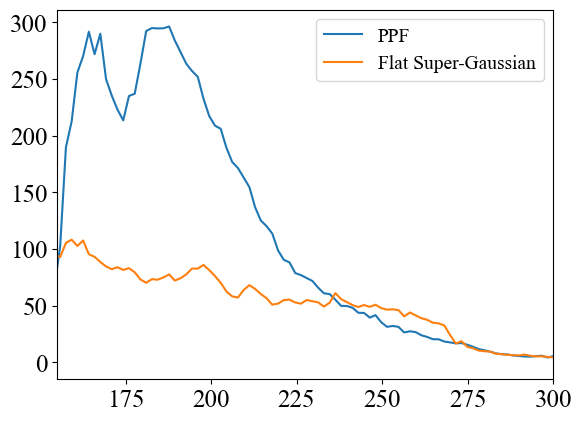

In [55]:
time_vals_density = np.linspace(0, 300, peak_ppf_45pw.shape[0])

plt.figure()
plt.plot(time_vals_density, peak_ppf_45pw, label="PPF")
plt.plot(time_vals_density, peak_gaussian_45pw, label="Flat Super-Gaussian")
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(155, 300)
#plt.savefig(FIGURE_DIRECTORY + "density_35pw.png")

## Fig. 6

In [56]:
S_echelon_high_res = happi.Open(ECHELON_PULSE_1PW_SIM_PATH, verbose=False)
S_gaussian_highres = happi.Open(GAUSSIAN_1PW_SIM_PATH, verbose=False)

/Users/kylecharbonnet/Code/UCI/barty-personal/jet_explore/experimental


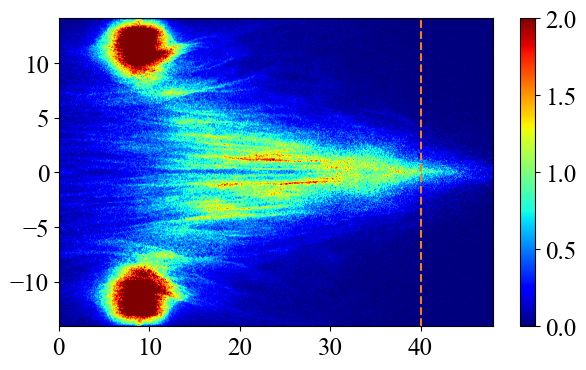

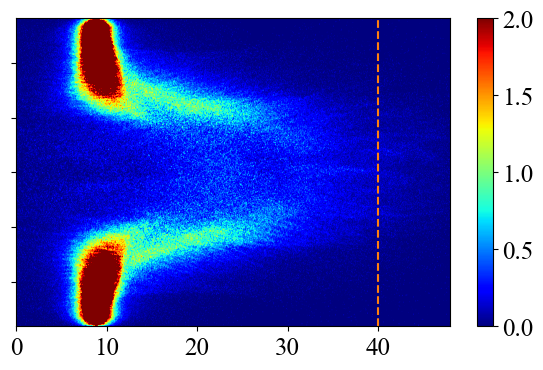

In [57]:
# HIGH RES XY Plots


T = 19000
FONT_SIZE = 18

echelon_data = np.array(S_echelon_high_res.Probe(0, "Rho_hydrogen_ions", units=['fs', 'um'], timesteps=T+1000).getData()[0])
gaussian_data = np.array(S_gaussian_highres.Probe(0, "Rho_hydrogen_ions", units=['fs', 'um'], timesteps=T+1000).getData()[0])
x_vals = np.linspace(0, 48, 1000)
y_vals = np.linspace(-14.08, 14.08, 1000)

VMAX = 2

plt.figure(figsize=(7, 4))
plt.imshow(echelon_data.T, aspect='auto', origin='lower', 
           extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]], cmap='jet', vmax=VMAX)
plt.tick_params(labelsize=FONT_SIZE)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE)
plt.axvline(x=40, color='tab:orange', linestyle='--')
#plt.savefig(FIGURE_DIRECTORY + "echelon_ions1pw_highres.png")

plt.figure(figsize=(7, 4))
plt.imshow(gaussian_data.T, aspect='auto', origin='lower', 
           extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]], cmap='jet', vmax=VMAX)
plt.tick_params(labelsize=FONT_SIZE)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE)
plt.tick_params(labelleft=False, labelsize=FONT_SIZE)
plt.axvline(x=40, color='tab:orange', linestyle='--')
#plt.savefig(FIGURE_DIRECTORY + "gaussian_ions1pw_highres.png")

0.5632361899538291
0.08514428306440301
6.615079365079603


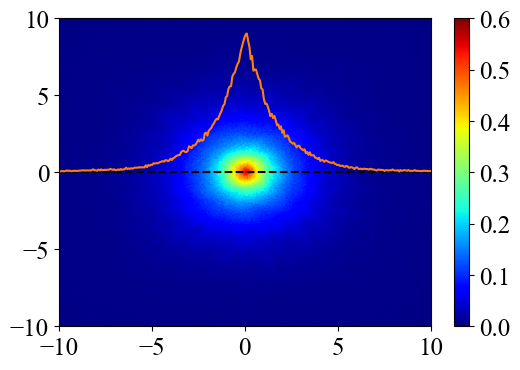

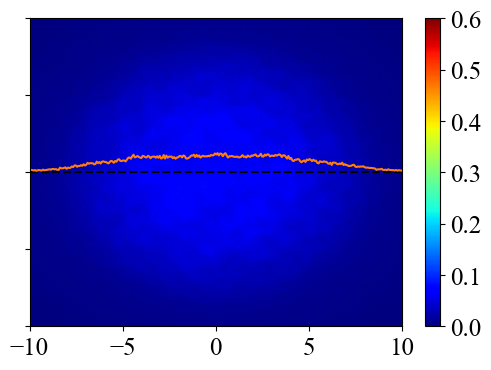

In [58]:
gaussian_data = np.array(S_gaussian_highres.Screen(0, units=['fs', 'um', '1/cm^3'], timesteps=99999).getData()[0])
echelon_data = np.array(S_echelon_high_res.Screen(0, units=['fs', 'um', '1/cm^3'], timesteps=99999).getData()[0])
L_x_cm = 48e-4
gaussian_data = gaussian_data * L_x_cm * scipy.constants.e
echelon_data = echelon_data * L_x_cm * scipy.constants.e

y_vals = np.linspace(-14.08, 14.08, 400)
SCALE = 16
VMAX = 0.6


plt.figure(figsize=(6, 4))
plt.imshow(echelon_data.T, aspect='auto', origin='lower', 
           extent=[y_vals[0], y_vals[-1], y_vals[0], y_vals[-1]], cmap='jet', vmax=VMAX)
plt.tick_params(labelsize=FONT_SIZE)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE)
plt.tick_params(labelsize=FONT_SIZE)
plt.axhline(y=0, color='black', linestyle='--')
plt.plot(y_vals, echelon_data[:, echelon_data.shape[1]//2] * SCALE, color='tab:orange')
plt.ylim(-10, 10)
plt.xlim(-10, 10)
print(echelon_data.max())
#plt.savefig(FIGURE_DIRECTORY + "echelon_screen_1pw_highres.png")

plt.figure(figsize=(6, 4))
plt.imshow(gaussian_data.T, aspect='auto', origin='lower', 
           extent=[y_vals[0], y_vals[-1], y_vals[0], y_vals[-1]], cmap='jet', vmax=VMAX)
plt.tick_params(labelsize=FONT_SIZE)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE)
plt.tick_params(labelleft=False, labelsize=FONT_SIZE)
plt.axhline(y=0, color='black', linestyle='--')
plt.plot(y_vals, gaussian_data[:, gaussian_data.shape[1]//2] * SCALE, color='tab:orange')
plt.ylim(-10, 10)
plt.xlim(-10, 10)
print(gaussian_data.max())
#plt.savefig(FIGURE_DIRECTORY + "gaussian_screen_1pw_highres.png")

print(echelon_data.max() / gaussian_data.max())

In [59]:
def get_divergence(S, screen):
    screen_diag = S.Screen(screen, units=['um', 'fs'], timesteps=99999)
    data = np.array(screen_diag.getData()[0])
    
    return data

theta_vals = np.linspace(-180, 180, 400)
SCREEN = 9
d40_echelon = get_divergence(S_echelon_high_res, SCREEN)
d40_gaussian = get_divergence(S_gaussian_highres, SCREEN)

In [60]:
from scipy.interpolate import UnivariateSpline

def fwhm(ind_var, dep_var, percent_max=(1 / (np.exp(2))), verbose=False):
    '''Find full width at specified percentage of maximum of data
    
    Parameters
    ----------
    name (data type) [physical unit]
    
    dep_var (array) []: the data to retrieve FWHM from
    ind_var (array) []: the x-axis values
    percent_max (float) []: (default = 0.5) percentage of maximum to evaluate full width at
    
    Returns
    -------
    fwhm (float) [ind_var units]: FWHM of data in the units of the independent variable x values
    '''

    spline = UnivariateSpline(ind_var, dep_var - np.max(dep_var) * percent_max, s=0)
    if np.size(spline.roots()) == 0:
        r1 = 0
        r2 = 0
    else:
        r1 = spline.roots()[0] # find the roots
        r2 = spline.roots()[-1]
    fwhm = np.abs(r1 - r2)
    
    if verbose:
        print('Full width @ ', percent_max, '* maximum = ', fwhm)
        
    return fwhm

fwhm_div = fwhm(theta_vals, d40_echelon, percent_max=.5)
fwhm_gaussian = fwhm(theta_vals, d40_gaussian, percent_max=.5)

print(fwhm_div, fwhm_gaussian)

3.459142636071008 12.86772979372154


In [61]:
# HIGH RES spectrum

TS = 20000
SPEC_BIN = 0
TS_GAUSSIAN_MAX = 15315
TS_ECHELON_MAX = 17722
sim_volume = (48e-4 * 28.08e-4 * 28.08e-4)
spec_echelon, energy_echelon = get_spectrum(S_echelon_high_res, SPEC_BIN, TS_ECHELON_MAX, sim_volume)

spec_gaussian, energy_gaussian = get_spectrum(S_gaussian_highres, SPEC_BIN, TS_GAUSSIAN_MAX, sim_volume)


peak_echelon, peak_time_echelon = getMaxIonEnergy(S_echelon_high_res)
peak_gaussian, peak_time_gaussian = getMaxIonEnergy(S_gaussian_highres)

print("Peak echelon and time:", peak_echelon, peak_time_echelon)
print("Peak gaussian and time:", peak_gaussian, peak_time_gaussian)

Peak echelon and time: 38.92628686675506 17722
Peak gaussian and time: 54.736096865350945 15315


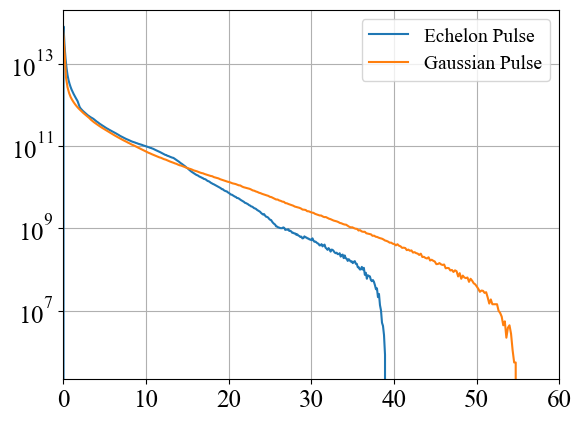

In [62]:
plt.figure()
plt.plot(energy_echelon, spec_echelon, label="Echelon Pulse")
#plt.plot(energy_ppf, spec_ppf, label="PPF")
plt.plot(energy_gaussian, spec_gaussian, label="Gaussian Pulse")

plt.legend(fontsize=14)
#plt.title("Spectrum")
#plt.ylim(0, 1e18)
plt.yscale('log')
plt.xlim(0, 60)
plt.tick_params(labelsize=18)
plt.grid()

#plt.savefig(FIGURE_DIRECTORY + "spectrum_high_res.png")